In [1]:
%load_ext autoreload
%autoreload 2


%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 12
from matplotlib import ticker
from matplotlib import patheffects
import numpy as np
import seaborn as sns
import xarray as xr

import covid19

def myLogFormat(y,pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

## data

In [3]:
#istat_path = 'comuni_giornaliero.csv'
#_, istat = covid19.data.read_istat(istat_path)

#istat_italy = istat.sel(year=2020).sum(['location', 'age_class'])
#istat_italy -= istat_italy.sel(time=slice(None, '2020-02-20')).mean()
#istat_italy = istat_italy.sel(time=slice(None, '2020-04-30'))
#istat_italy

In [198]:
# data_italy_path = 'dpc-covid19-ita-andamento-nazionale.csv'
data_italy_regions_path = 'dpc-covid19-ita-regioni.csv'

In [199]:
# data_italy_path = covid19.data.download('andamento-nazionale')
data_italy_regions_path = covid19.data.download('regioni')

In [200]:
ds_italy_regions = covid19.data.read_dpc(data_italy_regions_path)

# ds_italy_regions = ds_italy_regions.drop(dim='location', labels=['Italy / Lombardia'])

ds_italy_regions['daily_deaths'] = ds_italy_regions['deaths'].diff('time')

ds_italy_regions['daily_confirmed'] = ds_italy_regions['confirmed'].diff('time')
ds_italy_regions['daily_tests'] = ds_italy_regions['tests'].diff('time')
ds_italy_regions['daily_tested'] = ds_italy_regions['tested'].diff('time')

ds_italy_regions['daily_tpr'] = ds_italy_regions['daily_confirmed'] / ds_italy_regions['daily_tests']

ds_italy_regions['mortality'] = ds_italy_regions['deaths'] / ds_italy_regions['population'] * 1_000_000

ds_italy_regions['daily_mortality'] = ds_italy_regions['daily_deaths'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_prevalence'] = ds_italy_regions['daily_confirmed'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_tests_pm'] = ds_italy_regions['daily_tests'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['daily_tested_pm'] = ds_italy_regions['daily_tested'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['current_severe_pm'] = ds_italy_regions['current_severe'] / ds_italy_regions['population'] * 1_000_000
ds_italy_regions['current_critical_pm'] = ds_italy_regions['current_critical'] / ds_italy_regions['population'] * 1_000_000

for kind in ['daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_mortality', 'daily_prevalence', 'daily_tests_pm', 'daily_tested_pm',]:
    ds_italy_regions[kind + '7'] = ds_italy_regions[kind].rolling({'time': 7}).mean()

for kind in ['daily_confirmed', 'daily_deaths', 'daily_mortality', 'daily_prevalence']:
    ds_italy_regions[kind + '14'] = ds_italy_regions[kind].rolling({'time': 14}).mean()

ds_italy_regions['daily_tpr7'] = ds_italy_regions['daily_confirmed7'] / ds_italy_regions['daily_tests7']

ds_italy_regions = ds_italy_regions.fillna(0)
ds_italy_regions = ds_italy_regions.assign_coords({'location': ('location', [l.partition(' / ')[2] for l in ds_italy_regions.location.values])})
ds_italy_regions = ds_italy_regions.drop(['lat', 'lon', 'state_region', 'country'])

ds_italy_regions = ds_italy_regions.drop(['deaths', 'confirmed', 'tests', 'tested', 'mortality'])

# ds_italy_regions = ds_italy_regions.sel(time=slice(None, '2020-07-20'))

In [201]:
tmp = ds_italy_regions.sortby(-ds_italy_regions['daily_mortality7'].isel(time=-1)).isel(time=-1)
REGIONS = list(tmp.location.astype(str).values)
tmp.to_dataframe()  # [['daily_prevalence', 'daily_tpr']]

current_severe  current_critical  current_confirmed  \
location                                                                     
Friuli Venezia Giulia             654                56              13939   
P.A. Trento                       412                53               2707   
Valle d'Aosta                      74                 6                527   
Veneto                           2694               346              92690   
P.A. Bolzano                      208                24              10630   
Piemonte                         3761               266              50970   
Emilia-Romagna                   2797               214              64634   
Liguria                           768                71               8115   
Toscana                          1156               214              16264   
Lombardia                        4996               656              75890   
Molise                             59                 8               2658   
Umbria                            288                46               4560   
Puglia                           1530               187              52275   
Lazio                            2921               321              84221   
Abruzzo                           601                59              14467   
Campania                         1720               123              90242   
Basilicata                        106                11               6159   
Marche                            467                78              11890   
Sicilia                          1225               185              35969   
Sardegna                          570                58              15384   
Calabria                          335                21               9122   

                       population  daily_deaths  daily_confirmed  daily_tests  \
location                                                                        
Friuli Venezia Giulia     1217872          52.0            829.0       9766.0   
P.A. Trento                538604          14.0            377.0       1722.0   
Valle d'Aosta              126883           3.0             20.0        342.0   
Veneto                    4907529         165.0           3320.0      16880.0   
P.A. Bolzano               524256           8.0             88.0       1079.0   
Piemonte                  4392526          77.0           1106.0      18330.0   
Emilia-Romagna            4448841          74.0           1233.0      15770.0   
Liguria                   1565307          20.0            202.0       3899.0   
Toscana                   3742437          45.0            332.0       8572.0   
Lombardia                10018806         114.0           2404.0      27676.0   
Molise                     310449           3.0             37.0        606.0   
Umbria                     888908           4.0            179.0       4334.0   
Puglia                    4063888          54.0           1023.0      10163.0   
Lazio                     5898124          83.0           1159.0      15612.0   
Abruzzo                   1322247          15.0            100.0       1917.0   
Campania                  5839084          50.0            647.0       8441.0   
Basilicata                 570365           5.0             62.0        922.0   
Marche                    1538055          14.0            228.0       3356.0   
Sicilia                   5056641          31.0           1087.0       9086.0   
Sardegna                  1653135          12.0            231.0       3604.0   
Calabria                  1965128           3.0            175.0       2354.0   

                       daily_tested  daily_tpr  daily_mortality  ...  \
location                                                         ...   
Friuli Venezia Giulia        3845.0   0.084886        42.697426  ...   
P.A. Trento                   549.0   0.218931        25.993123  ...   
Valle d'Aosta                 111.0   0.058480        23.643829  ...   
Vene

In [202]:
ds_italy = ds_italy_regions.sum('location')
ds_italy['daily_mortality'] = ds_italy['daily_deaths'] / ds_italy['population'] * 1_000_000
ds_italy['daily_prevalence'] = ds_italy['daily_confirmed'] / ds_italy['population'] * 1_000_000
ds_italy['daily_tests_pm'] = ds_italy['daily_tests'] / ds_italy['population'] * 1_000_000
ds_italy['daily_tested_pm'] = ds_italy['daily_tested'] / ds_italy['population'] * 1_000_000
ds_italy['current_severe_pm'] = ds_italy['current_severe'] / ds_italy['population'] * 1_000_000
ds_italy['current_critical_pm'] = ds_italy['current_critical'] / ds_italy['population'] * 1_000_000

ds_italy['daily_tpr'] = ds_italy['daily_confirmed'] / ds_italy['daily_tests']

for kind in ['daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_mortality', 'daily_prevalence', 'daily_tests_pm', 'daily_tested_pm']:
    ds_italy[kind + '7'] = ds_italy[kind].rolling({'time': 7}).mean()

ds_italy['daily_confirmed14'] = ds_italy['daily_confirmed'].rolling({'time': 21}).mean()

ds_italy['daily_tpr7'] = ds_italy['daily_confirmed7'] / ds_italy['daily_tests7']

ds_italy.to_dataframe().tail(22)

current_severe  current_critical  current_confirmed  population  \
time                                                                          
2020-11-24           34577              3816             798386    60589085   
2020-11-25           34313              3848             791697    60589085   
2020-11-26           34038              3846             795845    60589085   
2020-11-27           33684              3782             787893    60589085   
2020-11-28           33299              3762             789308    60589085   
2020-11-29           32879              3753             795771    60589085   
2020-11-30           33187              3744             788471    60589085   
2020-12-01           32811              3663             779945    60589085   
2020-12-02           32454              3616             761230    60589085   
2020-12-03           31772              3597             759982    60589085   
2020-12-04           31200              3567             757702    60589085   
2020-12-05           30158              3517             754169    60589085   
2020-12-06           30391              3454             755306    60589085   
2020-12-07           30524              3382             748819    60589085   
2020-12-08           30081              3345             737525    60589085   
2020-12-09           29653              3320             710515    60589085   
2020-12-10           29088              3291             696527    60589085   
2020-12-11           28562              3265             690323    60589085   
2020-12-12           28066              3199             684848    60589085   
2020-12-13           27735              3158             686031    60589085   
2020-12-14           27765              3095             675109    60589085   
2020-12-15           27342              3003             663313    60589085   

            daily_deaths  daily_confirmed  daily_tests  daily_tested  \
time                                                                   
2020-11-24         853.0          23227.0     188659.0       95247.0   
2020-11-25         722.0          25852.0     230007.0      114177.0   
2020-11-26         822.0          29001.0     232711.0      110261.0   
2020-11-27         827.0          28342.0     222803.0      106021.0   
2020-11-28         686.0          26315.0     225940.0      112839.0   
2020-11-29         541.0          20646.0     176934.0       80132.0   
2020-11-30         672.0          16376.0     130524.0       64252.0   
2020-12-01         785.0          19347.0     182100.0       85112.0   
2020-12-02         684.0          20709.0     207143.0       95599.0   
2020-12-03         993.0          23219.0     220047.0       97592.0   
2020-12-04         814.0          24110.0     212741.0       83491.0   
2020-12-05         662.0          21052.0     194984.0      894721.0   
2020-12-06         564.0          18887.0     163550.0     -732995.0   
2020-12-07         528.0          13679.0     111217.0       53109.0   
2020-12-08         634.0          14837.0     149232.0       59551.0   
2020-12-09         499.0          12755.0     118475.0       50932.0   
2020-12-10         887.0          16998.0     171586.0       71113.0   
2020-12-11         761.0          18726.0     190416.0       78154.0   
2020-12-12         649.0          19902.0     196439.0       78563.0   
2020-12-13         484.0          17937.0     152697.0       70024.0   
2020-12-14         491.0          12025.0     103584.0       51152.0   
2020-12-15         846.0          14839.0     164431.0       64237.0   

            daily_tpr  daily_mortality  ...  daily_tested7  daily_mortality7  \
time                                    ...                                    
2020-11-24   0.123116        14.078443  ...  111252.142857         11.416483   
2020-11-25   0.112397        11.916338  ...  109815.000000         11.343392   
2020-11-26   0.124622        13.566800  ...  105795.571429        

## situation report

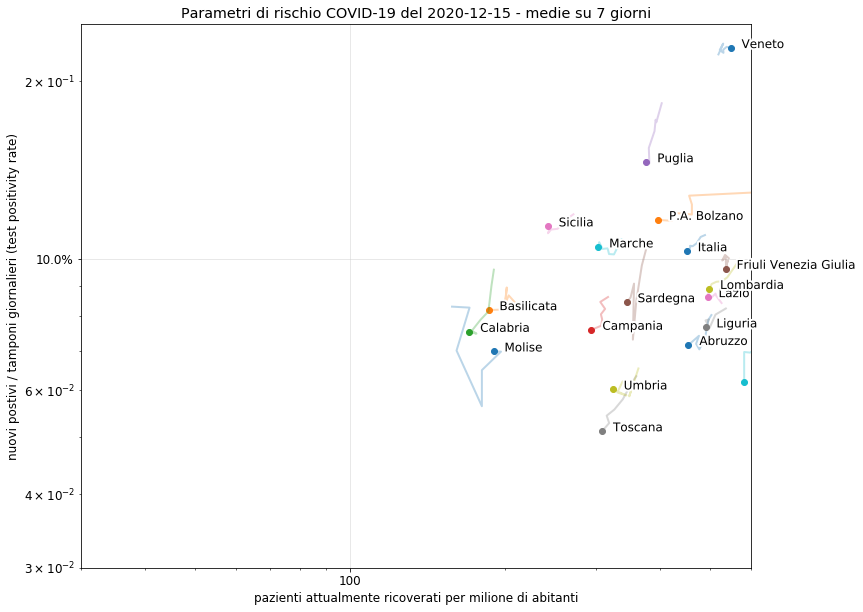

In [203]:
window = 7
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_tpr7']
var1 = rr['current_severe_pm']

it_rr = ds_italy.isel(time=slice(-window, None))
it_var = it_rr['daily_tpr7'].expand_dims(location=['Italia'])
it_var1 = (it_rr['current_severe_pm']).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

ylim = (0.03, .25)
xlim = (30, 600)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su 7 giorni',
    xlabel='pazienti attualmente ricoverati per milione di abitanti',
    ylabel='nuovi postivi / tamponi giornalieri (test positivity rate)',
)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))

# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

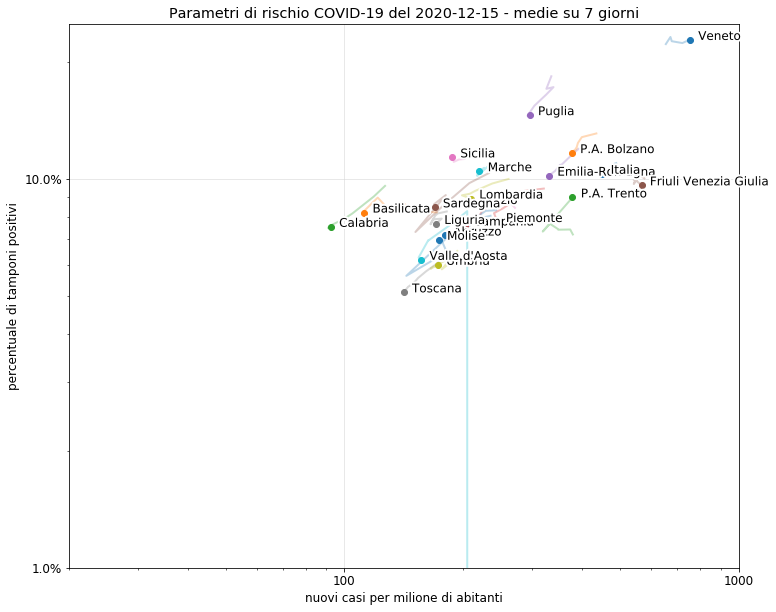

In [204]:
window = 7
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_tpr7']
var1 = rr['daily_prevalence7']

it_rr = ds_italy.isel(time=slice(-window, None))
it_var = it_rr['daily_tpr7'].expand_dims(location=['Italia'])
it_var1 = (it_rr['current_severe_pm']).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

ylim = (0.01, .25)
xlim = (20, 1000)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su 7 giorni',
    xlabel='nuovi casi per milione di abitanti',
    ylabel='percentuale di tamponi positivi',
)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))

# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

In [205]:
ds_italy_regions.sel(location="Umbria").to_dataframe()[['location', 'daily_tests', 'daily_confirmed', 'daily_deaths', 'current_severe', 'current_critical', 'daily_tpr', 'daily_tests7', 'daily_confirmed7', 'daily_deaths7', 'daily_tested7', 'current_confirmed', 'daily_tpr7']].tail(20)


location  daily_tests  daily_confirmed  daily_deaths  \
time                                                              
2020-11-26   Umbria       4791.0            343.0          14.0   
2020-11-27   Umbria       3955.0            261.0          14.0   
2020-11-28   Umbria       4262.0            348.0           6.0   
2020-11-29   Umbria       3232.0            310.0           5.0   
2020-11-30   Umbria        480.0             68.0          13.0   
2020-12-01   Umbria       4376.0            144.0           8.0   
2020-12-02   Umbria       4015.0            278.0          10.0   
2020-12-03   Umbria       3508.0            286.0          15.0   
2020-12-04   Umbria       3354.0            168.0           4.0   
2020-12-05   Umbria       3840.0            226.0           7.0   
2020-12-06   Umbria       2888.0            234.0           9.0   
2020-12-07   Umbria        377.0             65.0           8.0   
2020-12-08   Umbria       4005.0            135.0           9.0   
2020-12-09   Umbria        456.0             89.0           9.0   
2020-12-10   Umbria       3847.0            182.0          12.0   
2020-12-11   Umbria       3527.0            219.0           9.0   
2020-12-12   Umbria       3180.0            211.0          10.0   
2020-12-13   Umbria       2203.0            145.0           9.0   
2020-12-14   Umbria        308.0             49.0           5.0   
2020-12-15   Umbria       4334.0            179.0           4.0   

            current_severe  current_critical  daily_tpr  daily_tests7  \
time                                                                    
2020-11-26             349                68   0.071593   3902.142857   
2020-11-27             353                62   0.065992   3938.142857   
2020-11-28             351                64   0.081652   3868.714286   
2020-11-29             355                65   0.095916   3667.428571   
2020-11-30             366                65   0.141667   3672.000000   
2020-12-01             361                64   0.032907   3632.428571   
2020-12-02             342                62   0.069240   3587.285714   
2020-12-03             344                54   0.081528   3404.000000   
2020-12-04             327                57   0.050089   3318.142857   
2020-12-05             330                61   0.058854   3257.857143   
2020-12-06             332                60   0.081025   3208.714286   
2020-12-07             338                56   0.172414   3194.000000   
2020-12-08             318                57   0.033708   3141.000000   
2020-12-09             323                56   0.195175   2632.571429   
2020-12-10             310                55   0.047310   2681.000000   
2020-12-11             314                54   0.062092   2705.714286   
2020-12-12             301                49   0.066352   2611.428571   
2020-12-13             294                45   0.065819   2513.571429   
2020-12-14             306                41   0.159091   2503.714286   
2020-12-15             288                46   0.041301   2550.714286   

            daily_confirmed7  daily_deaths7  daily_tested7  current_confirmed  \
time                                                                            
2020-11-26        322.000000      10.857143    1537.285714               9434   
2020-11-27        303.000000       9.857143    1475.000000               9050   
2020-11-28        294.428571       9.428571    1395.571429               8653   
2020-11-29        281.571429       8.714286    1259.857143               8443   
2020-11-30        276.285714      10.000000    1263.571429               8235   
2020-12-01        265.714286       9.714286    1212.571429               7680   
2020-12-02        250.285714      10.000000    1143.428571               7083   
2020-12-03        242.142857      10.142857    1079.428571               6762   
2020-12-04        228.857143       8.714286    1034.142857               6423   
2020-12-05        211.428571       8.8

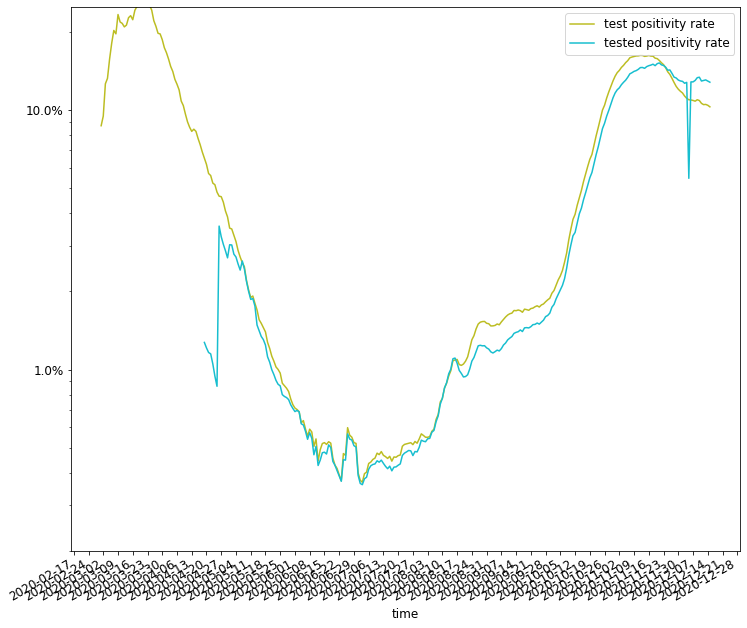

In [206]:
_, ax = plt.subplots()
ax.set(yscale='log', title='nuovi postivi / tamponi giornalieri (test positivity rate)')
covid19.plot.plot_data(ax, ds_italy['daily_tpr7'], label='test positivity rate',  marker=None)
data = ds_italy['daily_confirmed7'] / ds_italy['daily_tested7']
covid19.plot.plot_data(ax, data, label='tested positivity rate', marker=None, ratio=1.9)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
ax.set(ylim=(0.002, 0.25))
_ = ax.legend()

In [207]:
tmp = ds_italy_regions.sel(location='Liguria').to_dataframe()
tmp['tpr'] = tmp['daily_confirmed'] / tmp['daily_tests']
tmp['tpr7'] = tmp['daily_confirmed7'] / tmp['daily_tests7']
tmp.tail(12)

current_severe  current_critical  current_confirmed  population  \
time                                                                          
2020-12-04             912                99              11027     1565307   
2020-12-05             897                93              10518     1565307   
2020-12-06             868                92              10416     1565307   
2020-12-07             867                92              10010     1565307   
2020-12-08             841                91               9745     1565307   
2020-12-09             841                88               9247     1565307   
2020-12-10             822                85               8958     1565307   
2020-12-11             803                84               8765     1565307   
2020-12-12             782                77               8469     1565307   
2020-12-13             768                75               8395     1565307   
2020-12-14             780                73               8280     1565307   
2020-12-15             768                71               8115     1565307   

            daily_deaths  daily_confirmed  daily_tests  daily_tested  \
time                                                                   
2020-12-04          25.0            367.0       4765.0        1455.0   
2020-12-05          27.0            314.0       3708.0        1000.0   
2020-12-06          20.0            304.0       3092.0         930.0   
2020-12-07          23.0            128.0       1424.0         452.0   
2020-12-08          19.0            266.0       3957.0        1096.0   
2020-12-09          28.0            191.0       2248.0         574.0   
2020-12-10          11.0            320.0       3992.0        1517.0   
2020-12-11          25.0            340.0       4707.0        1197.0   
2020-12-12          22.0            263.0       4277.0        1204.0   
2020-12-13           8.0            331.0       2752.0         836.0   
2020-12-14          17.0            223.0       2533.0        1106.0   
2020-12-15          20.0            202.0       3899.0        1012.0   

            daily_tpr  daily_mortality  ...  daily_tests_pm7  \
time                                    ...                    
2020-12-04   0.077020        15.971308  ...      2677.886374   
2020-12-05   0.084682        17.249012  ...      2583.701289   
2020-12-06   0.098318        12.777046  ...      2513.701329   
2020-12-07   0.089888        14.693603  ...      2451.915183   
2020-12-08   0.067223        12.138194  ...      2420.611420   
2020-12-09   0.084964        17.887865  ...      2204.131750   
2020-12-10   0.080160         7.027375  ...      2116.061395   
2020-12-11   0.072233        15.971308  ...      2110.768047   
2020-12-12   0.061492        14.054751  ...      2162.697614   
2020-12-13   0.120276         5.110819  ...      2131.667645   
2020-12-14   0.088038        10.860489  ...      2232.880104   
2020-12-15   0.051808        12.777046  ...      2227.586756   

            daily_tested_pm7  daily_confirmed14  daily_deaths14  \
time                                                              
2020-12-04        798.839187         457.571429       19.071429   
2020-12-05        753.571937         425.642857       19.571429   
2020-12-06        733.128663         403.714286       20.000000   
2020-12-07        708.669746         392.500000       20.214286   
2020-12-08        687.678884         375.142857       19.785714   
2020-12-09        619.595481         355.928571       20.214286   
2020-12-10        641.042665         338.071429       20.000000   
2020-12-11        617.496394         319.071429       20.785714   
2020-12-12        636.114376         305.428571       20.571429   
2020-12-13        627.535502         297.857143       19.785714   
2020-12-14        687.222561         296.928571       20.500000   
2020-12-15        679.556333         287.142857       20.714286   

            daily_mortality14  daily_prevalence14  daily_tpr

In [208]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

START_FIT = '2020-02-23'
STOP_FIT = '2020-04-01'

LAST_DAY = ds_italy.time[-1].values
SHOWUNTIL = LAST_DAY + 30 * DAY

EXTRAPOLATE = (np.datetime64('2020-03-01'), SHOWUNTIL)
XLIM = EXTRAPOLATE

XXX = ['daily_tests_pm7', 'daily_prevalence7', 'current_severe_pm', 'current_critical_pm', 'daily_mortality7'] 
FIT_PARAMS = {
    'daily_tests_pm7': [],
    'daily_prevalence7': ['2020-07-19', '2020-10-06'],
    'current_severe_pm': ['2020-08-13', '2020-10-06'],
    'current_critical_pm': ['2020-08-07', '2020-10-10'],
    'daily_mortality7': ['2020-08-19', '2020-10-12'],
    'daily_tpr7': [],
    'daily_confirmed7': ['2020-10-06', '2020-10-19', '2020-10-21', '2020-10-23', '2020-11-01', '2020-11-23', None],
    'daily_deaths7': ['2020-10-15', '2020-10-29', '2020-11-12', '2020-11-18'],
}
#FIT_PARAMS = {
#    'daily_tests_pm7': [],
#    'daily_prevalence7': [],
#    'current_severe_pm': [],
#    'current_critical_pm': ['2020-04-15', '2020-07-10'],
#    'daily_mortality7': ['2020-04-19', '2020-08-01'],
#    'daily_tpr7': [],
#    'daily_confirmed7': ['2020-10-06', None],
#}
RATIO = {
    'current_critical_pm': 0.165,
    'daily_mortality7': 0.013,
}
DEALY = {
    'current_critical_pm': -5,
    'daily_mortality7': -7.5,
}
LABEL = {
    'current_severe': 'pazienti attualmente ricoverati in reparto',
    'current_confirmed': 'attualmente positivi',
    'current_severe_pm': 'pazienti attualmente ricoverati in reparto',
    'current_critical': 'pazienti attualmente in terapia intensiva',
    'current_critical_pm': 'pazienti attualmente in terapia intensiva',
    'daily_tests7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tests_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tested7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_deaths': 'decessi giornalieri',
    'daily_deaths7': 'decessi giornalieri (media su 7 giorni)',
    'daily_confirmed7': 'nuovi casi giornalieri (media su 7 giorni)',
    'daily_deaths14': 'decessi giornalieri (media su 14 giorni)',
    'daily_confirmed14': 'nuovi casi giornalieri (media su 14 giorni)',
    'daily_prevalence7': 'nuovi casi giornalieri (media su 7 giorni)',
    'daily_tpr7': 'percentuale di test positivi (media su 7 giorni)',
    'daily_prevalence_screening7': 'nuovi casi da screening (media su 7 giorni)',
    'daily_tests_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_tested_pm7': 'tamponi giornalieri (media su 7 giorni)',
    'daily_mortality7': 'decessi giornalieri (media su 7 giorni)',
    'daily_mortality14': 'decessi giornalieri (media su 14 giorni)',
}

In [209]:
fits = {}
for kind, breaks in FIT_PARAMS.items():
    if isinstance(breaks, int):
        breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in FIT_PARAMS['current_severe']]
    fits[kind] = covid19.fit.fit_exponential_segments(ds_italy[kind], breaks=breaks, min_value=0, valid_ratio=0.1)

# fits['daily_deaths7'] = [fit.shift(7).scale(0.013) for fit in fits['daily_confirmed7']]
# fits['daily_confirmed7'].append(fits['daily_confirmed7'][-1].scale(.75))

# fits

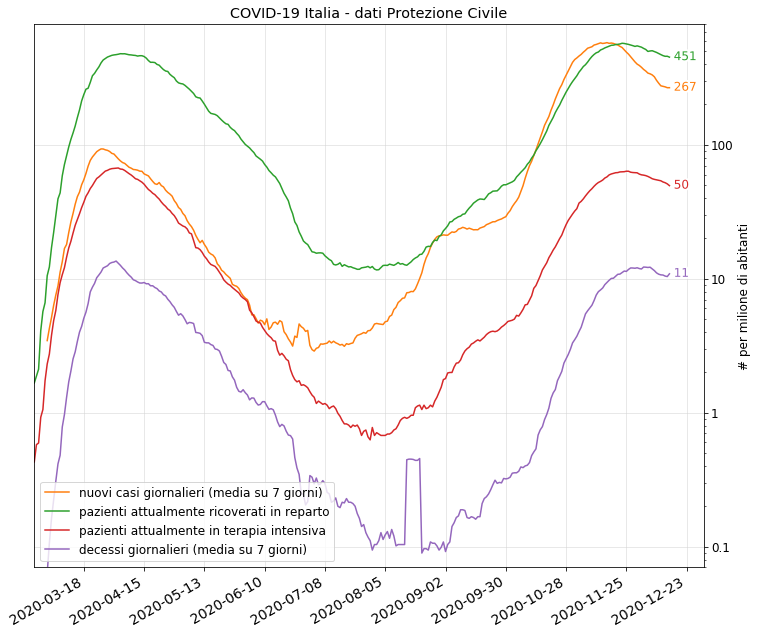

In [210]:
SHOW = ['daily_prevalence7', 'current_severe_pm', 'current_critical_pm', 'daily_mortality7']

EXTRAPOLATE = (np.datetime64('2020-02-24'), np.datetime64('2020-12-31'))
XLIM = EXTRAPOLATE

_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (0.07, 800)})

for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    if SHOW is not None and kind not in SHOW:
        continue
    label = LABEL.get(kind, '')
    ratio = RATIO.get(kind, 1.)
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color, date_interval=28, marker=None, annotate=True)
    #for i, fit in enumerate(fits_kind):
    #    covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[0, 7], alpha=0.5)

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)
    
_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="# per milione di abitanti")
_ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
_ = ax.legend(loc='lower left')

[20700 23200 24100 21100 18900 13700 14800 14000 19000 20100 17100 15100
 10000 11300 10500 15700 16900 14000 12100  7100  8500]
[15111. 16936. 17593. 15403. 13797. 10001. 10804. 10220. 13870. 14673.
 12483. 11023.  7300.  8249.  7665. 11461. 12337. 10220.  8833.  5183.
  6205.]


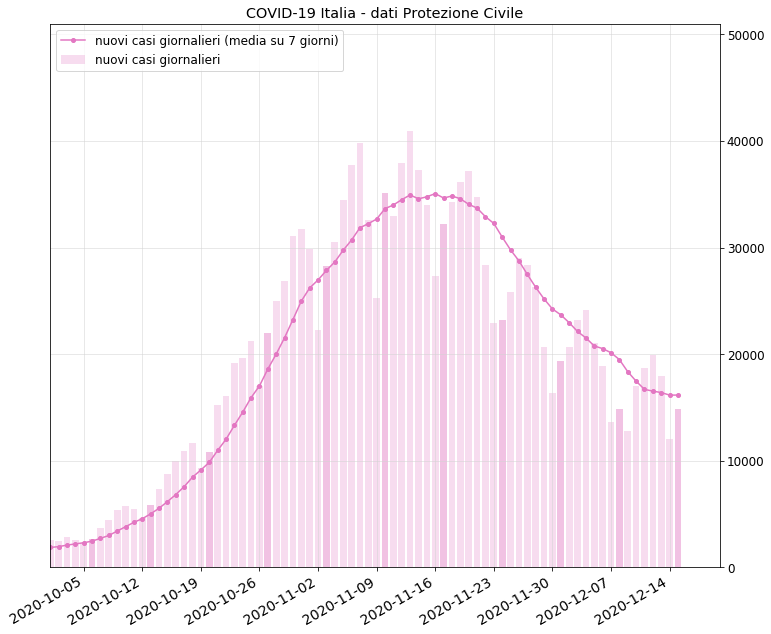

In [236]:
HIGHLIGHT_DAY = 1

SHOW = ['daily_confirmed7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-12-20')), 'ylim': (0, 51000)})

count = 0
for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color, date_interval=7, markersize=4)
    try:
        ax.bar(ds_italy.time, ds_italy[kind[:-1]], color=color, alpha=0.25, label='nuovi casi giornalieri')
        ax.bar(ds_italy.time[HIGHLIGHT_DAY::7], ds_italy[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    #for i, fit in enumerate(fits_kind[-1:]):
    #    covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-3,7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

# ax.plot([np.datetime64('2020-11-07') + i * DAY for i in range(-6, 8)], 0.73 * np.array([37000, 32500, 38700, 43100, 46400, 52200, 54600, 61800, 59200, 67700, 74400, 80200, 88800, 94200]), ' x', color=color, label='nuovi casi giornalieri nello scenario del 2020-10-28')

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))


means = []
values = list(ds_italy['daily_confirmed'][-14:-7].values)
for i in range(-6, 8):
    mean = fit.predict(LAST_DAY + i * DAY)
    means.append(round(mean))
    values.append(round(mean * 7 - sum(values[-6:])))
print(np.array([int(round(v / 100)) * 100 for v in values]))
print(0.73 * np.array([int(round(v / 100)) * 100 for v in values]))

[  3400   3800   4500   3100   2400   1600   1700 112700   -400    500
   -800  -1400  -2100  -1900 109300  -3700  -2700  -3900  -4400  -5000
  -4700]
[3060.0, 3420.0, 4050.0, 2790.0, 2160.0, 1440.0, 1530.0, 101430.0, -360.0, 450.0, -720.0, -1260.0, -1890.0, -1710.0, 98370.0, -3330.0, -2430.0, -3510.0, -3960.0, -4500.0, -4230.0]


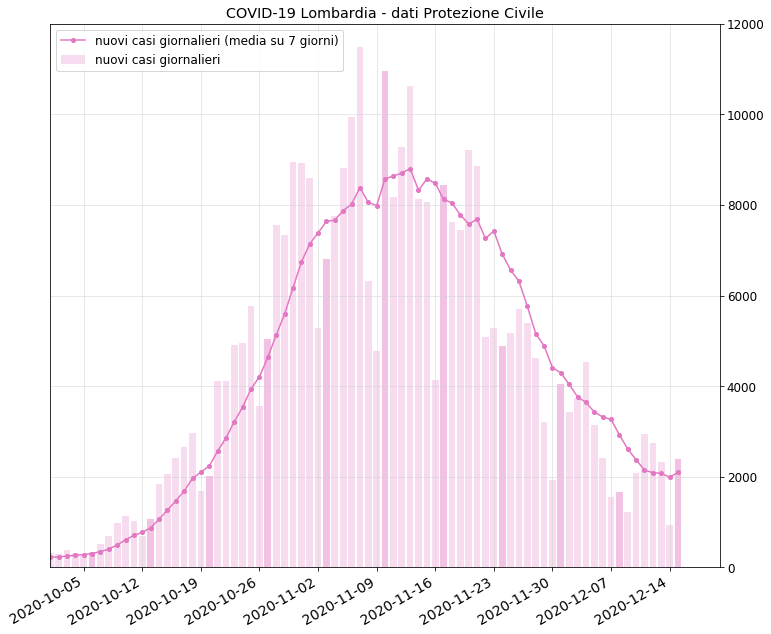

In [216]:
SHOW = ['daily_confirmed7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-12-20')), 'ylim': (0, 12000)})

data = ds_italy_regions.sel(location='Lombardia')

count = 0
for (kind, fits_kind), color in zip(region_fits['Lombardia'].items(), PALETTE_ONE):
    color = 'tab:pink'
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, data[kind], label=label, color=color, date_interval=7, markersize=4)
    try:
        ax.bar(ds_italy.time, data[kind[:-1]], color=color, alpha=0.25, label='nuovi casi giornalieri')
        ax.bar(ds_italy.time[HIGHLIGHT_DAY::7], data[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    #for i, fit in enumerate(fits_kind):
    #    covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-3,7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

# ax.plot([np.datetime64('2020-11-07') + i * DAY for i in range(-6, 8)], 0.73 * np.array([9270.0, 7650.0, 9450.0, 12150.0, 12510.0, 14580.0, 15120.0, 17100.0, 16200.0, 18810.0, 22410.0, 23760.0, 26820.0, 28620.0]), ' x', color=color, label='nuovi casi giornalieri nello scenario del 2020-10-28')

_ = ax.set_title(f'COVID-19 Lombardia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))


means = []
values = list(data['daily_confirmed'][-14:-7].values)
for i in range(-6, 8):
    mean = fit.predict(LAST_DAY + i * DAY)
    means.append(round(mean))
    values.append(round(mean * 7 - sum(values[-6:])))
print(np.array([int(round(v / 100)) * 100 for v in values]))
print((0.9 * np.array([int(round(v / 100)) * 100 for v in values])).tolist())

(0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
[14745, 14271, 13813, 13368, 12939, 12523, 12120]
[499, 887, 761, 649, 484, 491, 846, 99100, -2432, -2450, -2460, -2524, -2421, -1972]


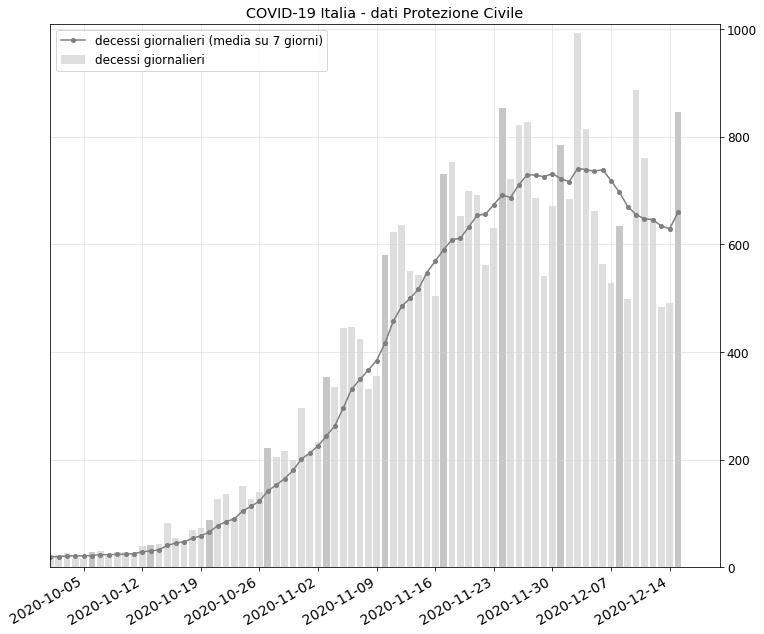

In [217]:
SHOW = ['daily_deaths7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-12-20')), 'ylim': (0, 1010)})

data = ds_italy
fits_data = fits

count = 0
for (kind, fits_kind), color in zip(fits_data.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    print(color)
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, data[kind], label=label, color=color, date_interval=7, markersize=4)
    try:
        ax.bar(data.time, data[kind[:-1]], color=color, alpha=0.25, label='decessi giornalieri')
        ax.bar(data.time[HIGHLIGHT_DAY::7], data[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    #for i, fit in enumerate(fits_kind[-2:]):
    #    covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-3,7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

# ax.plot([np.datetime64('2020-11-23') + i * DAY for i in range(1, 8)], [835, 858, 760, 809, 804, 676, 747], ' x', color=color, label='stima dei decessi nello scenario del 2020-11-16')

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))


means = []
values = [int(v) for v in ds_italy['daily_deaths'].isel(time=slice(-7, None)).values]
for i in range(1, 8):
    mean = fit.predict(LAST_DAY + i * DAY)
    means.append(int(round(mean)))
    value = int(round(mean * 7 - sum(values[-6:])))
    values.append(value)
print(means)
print(values)

(0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
[14745, 14271, 13813, 13368, 12939, 12523, 12120]
[359, 630, 530, 501, 302, 376, 652, 100227, -2689, -2681, -2608, -2706, -2536, -2166]


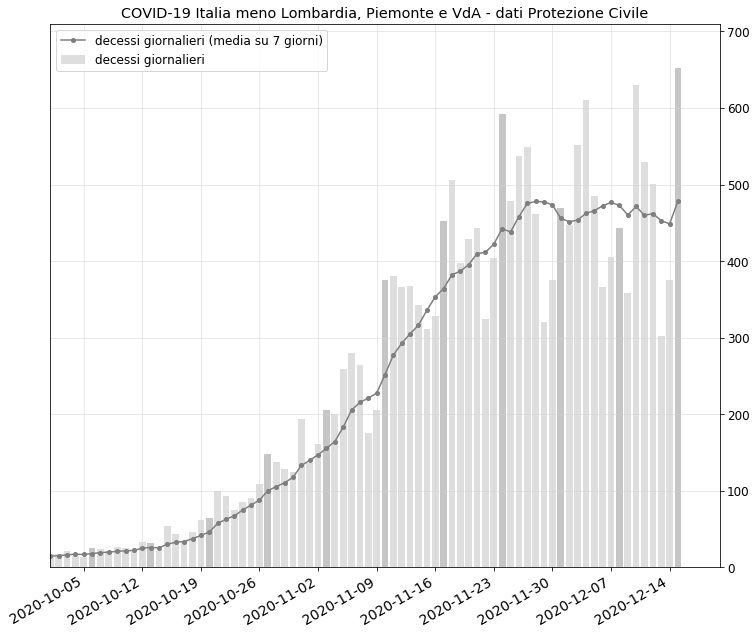

In [218]:
SHOW = ['daily_deaths7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-12-20')), 'ylim': (0, 710)})

data = ds_italy - (ds_italy_regions.sel(location='Lombardia') + ds_italy_regions.sel(location='Piemonte') + ds_italy_regions.sel(location="Valle d'Aosta"))
fits_data = region_fits['Lombardia']

count = 0
for (kind, fits_kind), color in zip(fits_data.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    print(color)
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, data[kind], label=label, color=color, date_interval=7, markersize=4)
    try:
        ax.bar(data.time, data[kind[:-1]], color=color, alpha=0.25, label='decessi giornalieri')
        ax.bar(data.time[HIGHLIGHT_DAY::7], data[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    #for i, fit in enumerate(fits_kind[-2:]):
    #    covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-3,7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

#ax.plot([np.datetime64('2020-11-16') + i * DAY for i in range(1, 8)], [182, 191, 229, 160, 203, 227, 147], ' x', color=color, label='stima dei decessi nello scenario del 2020-11-16')

_ = ax.set_title(f'COVID-19 Italia meno Lombardia, Piemonte e VdA - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))


means = []
values = [int(v) for v in data['daily_deaths'].isel(time=slice(-7, None)).values]
for i in range(1, 8):
    mean = fit.predict(LAST_DAY + i * DAY)
    means.append(int(round(mean)))
    value = int(round(mean * 7 - sum(values[-6:])))
    values.append(value)
print(means)
print(values)

(0.4980392156862745, 0.4980392156862745, 0.4980392156862745)


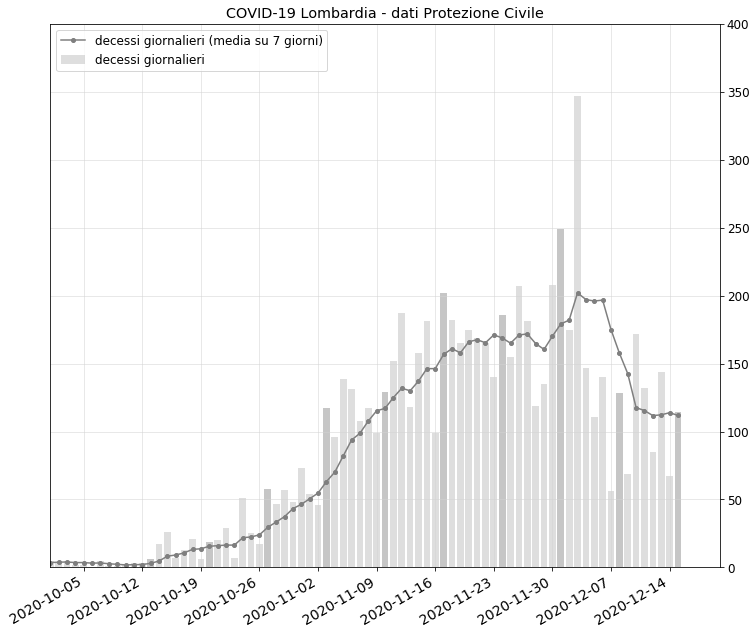

In [219]:
SHOW = ['daily_deaths7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-12-20')), 'ylim': (0, 400)})

data = ds_italy_regions.sel(location='Lombardia') # + ds_italy_regions.sel(location='Piemonte') + ds_italy_regions.sel(location="Valle d'Aosta")
fits_data = region_fits['Lombardia']

count = 0
for (kind, fits_kind), color in zip(fits_data.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    print(color)
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, data[kind], label=label, color=color, date_interval=7, markersize=4)
    try:
        ax.bar(data.time, data[kind[:-1]], color=color, alpha=0.25, label='decessi giornalieri')
        ax.bar(data.time[HIGHLIGHT_DAY::7], data[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    #for i, fit in enumerate(fits_kind[-2:]):
    #    covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-3,7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

#ax.plot([np.datetime64('2020-11-16') + i * DAY for i in range(1, 8)], [182, 191, 229, 160, 203, 227, 147], ' x', color=color, label='stima dei decessi nello scenario del 2020-11-16')

_ = ax.set_title(f'COVID-19 Lombardia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
_ = ax.set(ylim=(0, None))


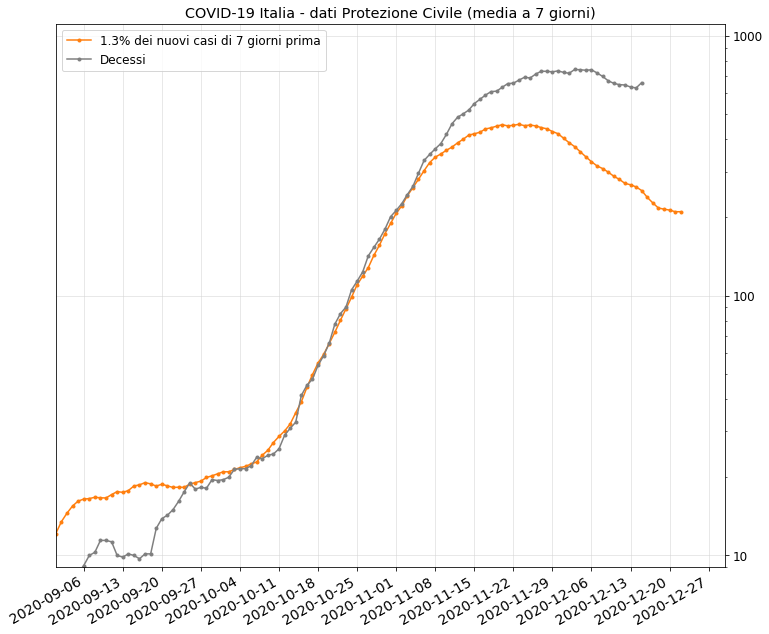

In [220]:
shift = 7
scale = 0.013

color_deaths = (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)

_, ax = covid19.plot.subplots(subplot_kw={'xlim': (np.datetime64('2020-09-01'), np.datetime64('2020-12-30')), 'yscale': 'log', 'ylim': (9, 1000 / 0.9)})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], delay=shift, ratio=1/scale, label=f'{scale * 100:.2g}% dei nuovi casi di {shift} giorni prima', color='tab:orange', markersize=3)
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], label='Decessi', color=color_deaths, date_interval=7, markersize=3)
#covid19.plot.plot_fit(ax, fits['daily_deaths7'][-3], marker=None, color=color_deaths, extrapolate=(-4, 7), label='stima')
#covid19.plot.plot_fit(ax, fits['daily_deaths7'][-2], marker=None, color=color_deaths, extrapolate=(-4, 7), label='stima')
#covid19.plot.plot_fit(ax, fits['daily_deaths7'][-1], marker=None, color=color_deaths, extrapolate=(-4, 7), label='stima')
_ = ax.legend(loc='upper left')
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile (media a 7 giorni)', ylabel='', xlabel='')

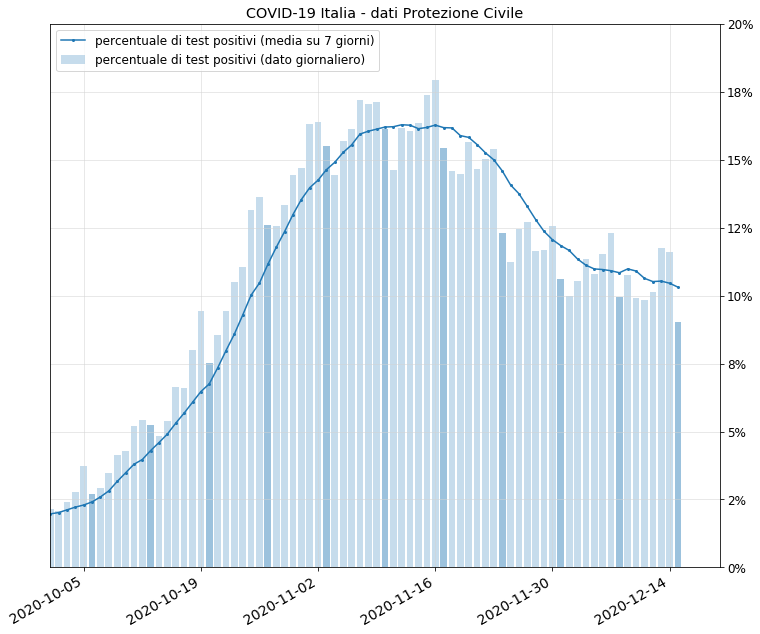

In [221]:
SHOW = ['daily_tpr7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-12-20')), 'ylim': (0, 0.20)})

count = 0
for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    color = 'tab:blue'
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color, date_interval=14)
    try:
        ax.bar(ds_italy.time, ds_italy[kind[:-1]], color=color, alpha=0.25, label='percentuale di test positivi (dato giornaliero)')
        ax.bar(ds_italy.time[HIGHLIGHT_DAY::7], ds_italy[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    for i, fit in enumerate(fits_kind):
        covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[0, 7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(ylim=(0, None))

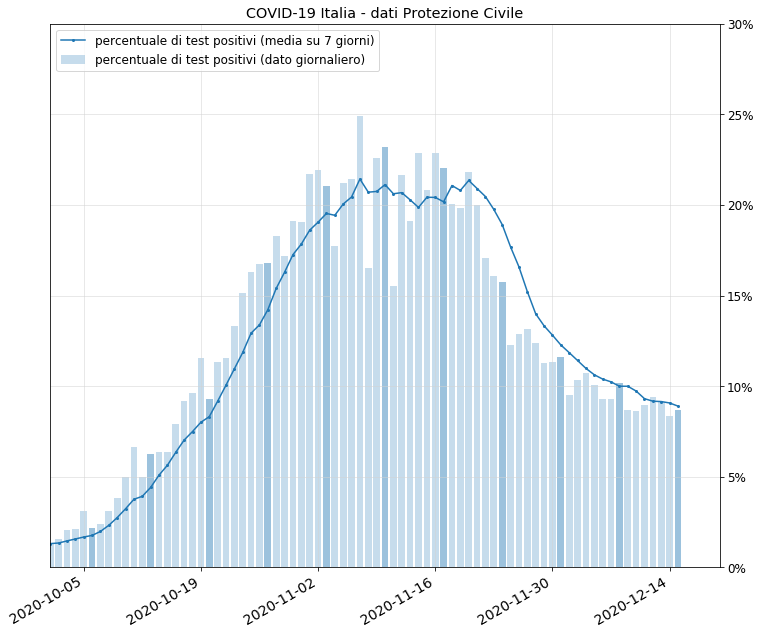

In [222]:
SHOW = ['daily_tpr7']

_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-12-20')), 'ylim': (0, 0.30)})

data = ds_italy_regions.sel(location='Lombardia')

count = 0
for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    count += 1
    if SHOW is not None and kind not in SHOW:
        continue
    color = 'tab:blue'
    ratio = RATIO.get(kind, 1)
    label = LABEL.get(kind, '')
    covid19.plot.plot_data(ax, data[kind], label=label, color=color, date_interval=14)
    try:
        ax.bar(data.time, data[kind[:-1]], color=color, alpha=0.25, label='percentuale di test positivi (dato giornaliero)')
        ax.bar(data.time[HIGHLIGHT_DAY::7], data[kind[:-1]][HIGHLIGHT_DAY::7], color=color, alpha=0.25)
    except:
        pass
    for i, fit in enumerate(fits_kind):
        covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[0, 7])

# covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(ylim=(0, None))

In [223]:
REGIONS_FIT_PARAMS_DEFAULT = {
    'daily_tests_pm7': [],
    'daily_prevalence7': ['2020-07-10', None],
    'current_severe_pm': ['2020-07-20', None],
    'current_critical_pm': ['2020-07-25', None],
    'daily_mortality7': ['2020-09-01', None],
}
REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'daily_tests7': [],
        'daily_prevalence7': ['2020-07-23', '2020-10-06', None],
        'current_severe_pm': [],
        'current_critical_pm': ['2020-08-05', '2020-10-10', None],
        'daily_mortality7': ['2020-08-01', '2020-10-15', None],
        'daily_confirmed7': ['2020-10-06', '2020-10-23', '2020-11-01', None],
        'daily_deaths7': ['2020-10-15', '2020-11-09', '2020-11-22'],
        'daily_confirmed14': ['2020-10-06', '2020-10-23', '2020-11-01', None],
        'daily_deaths14': ['2020-10-15', '2020-11-09', '2020-11-22'],
    },
    'Lazio': {
        'daily_prevalence7': ['2020-08-01', None],
        'current_severe_pm': [],
        'current_critical_pm': ['2020-08-25', None],
        'daily_mortality7': ['2020-09-05', None],
    },
    'Campania': {
    },
    'Sicilia': {
        'daily_prevalence7': ['2020-07-17', None],
        'daily_mortality7': ['2020-09-15', None],
    },
    'Veneto': {
        'daily_prevalence7': ['2020-07-10', None],
        'current_severe_pm': ['2020-08-10', None],
    },
    'Emilia-Romagna': {
        'daily_prevalence7': ['2020-06-10', None],        
    },
    'Sardegna': {
        'daily_prevalence7': ['2020-07-10', '2020-09-05', None],
        'current_severe_pm': ['2020-08-01', None],
        'current_critical_pm': [],
    },
    'Liguria': {
        'current_severe_pm': [],
    },
    'Puglia': {
        'daily_prevalence7': ['2020-07-20', '2020-09-10'],
        'current_severe_pm': ['2020-07-20', '2020-09-10'],
        'current_critical_pm': ['2020-07-25', '2020-09-20'],
    },
    'Marche':{
        'daily_prevalence7': ['2020-07-30', None],
    },
    'Basilicata': {
        'daily_prevalence7': ['2020-07-20', None],
    },
 }

STOP_FIT = '2020-04-03'

region_fits = {}
for region in REGIONS:
    params = REGIONS_FIT_PARAMS_DEFAULT.copy()
    params.update(REGIONS_FIT_PARAMS.get(region, {}))
    region_fits[region] = {}
    for kind, breaks in params.items():
        if isinstance(breaks, int):
            breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in params['current_severe']]
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds_italy_regions.sel(location=region)[kind], breaks=breaks, min_value=0, valid_ratio=0.1)

In [224]:
EXTRAPOLATE = (np.datetime64('2020-09-15'), np.datetime64('2020-12-20'))
XLIM = EXTRAPOLATE

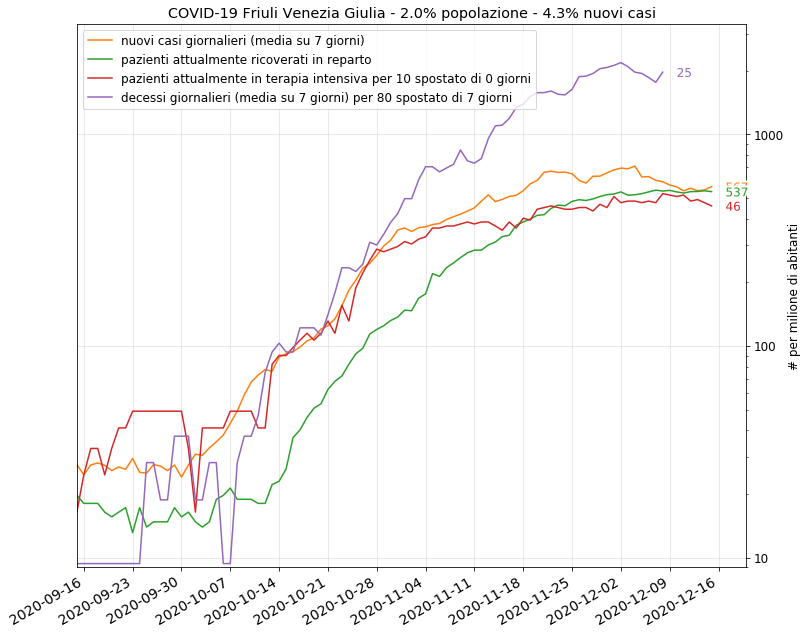

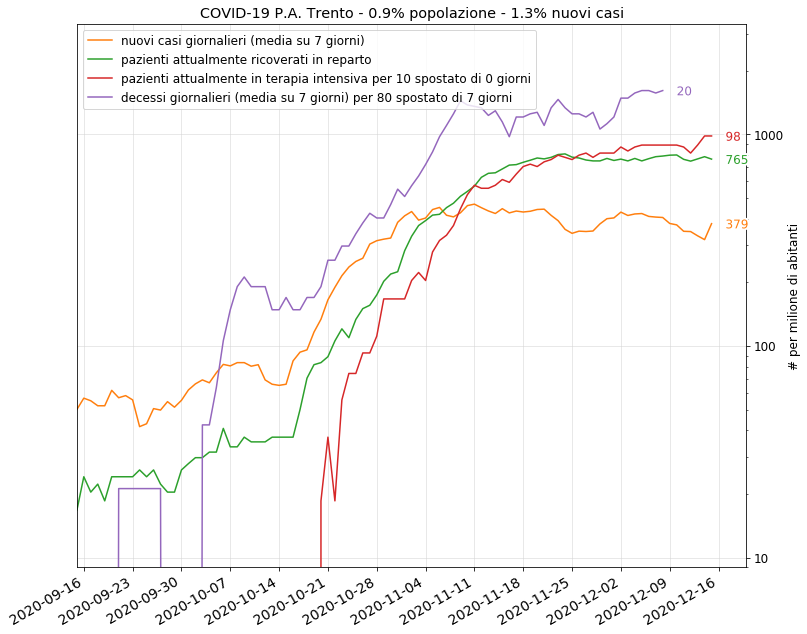

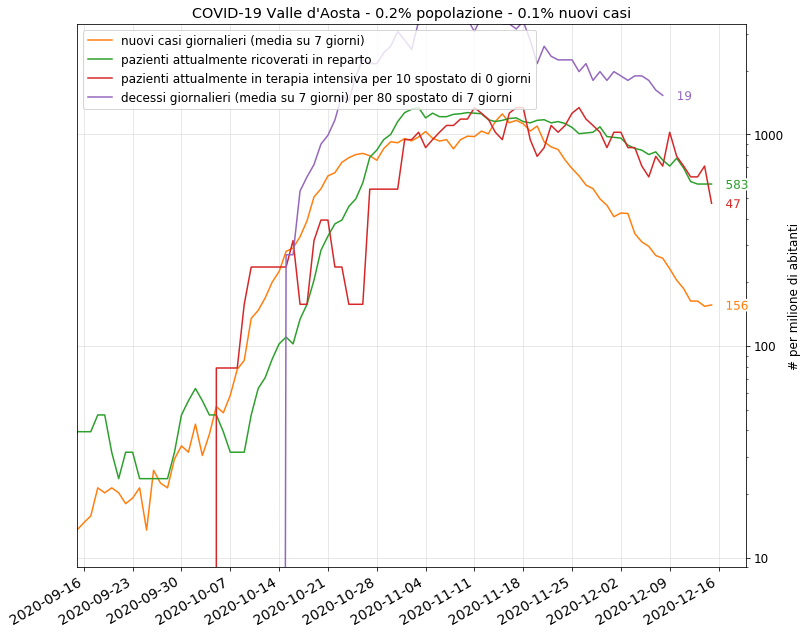

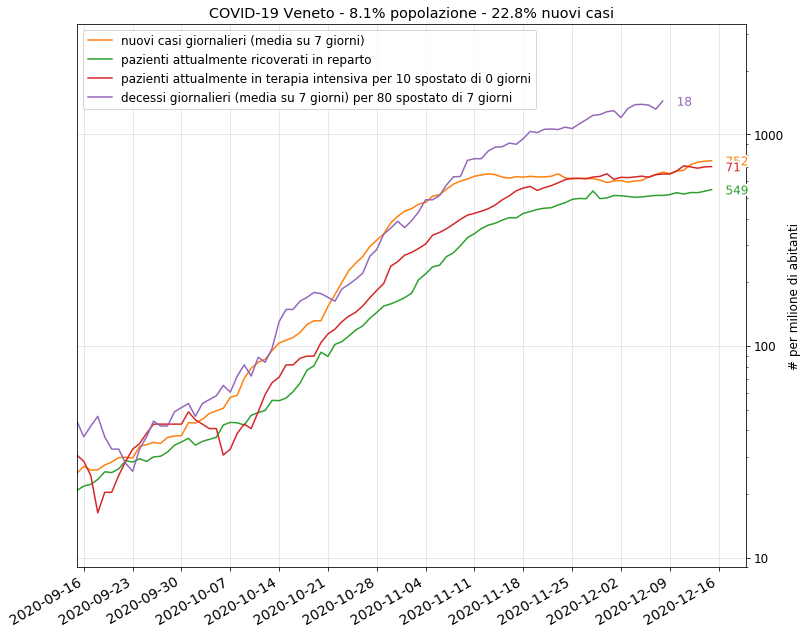

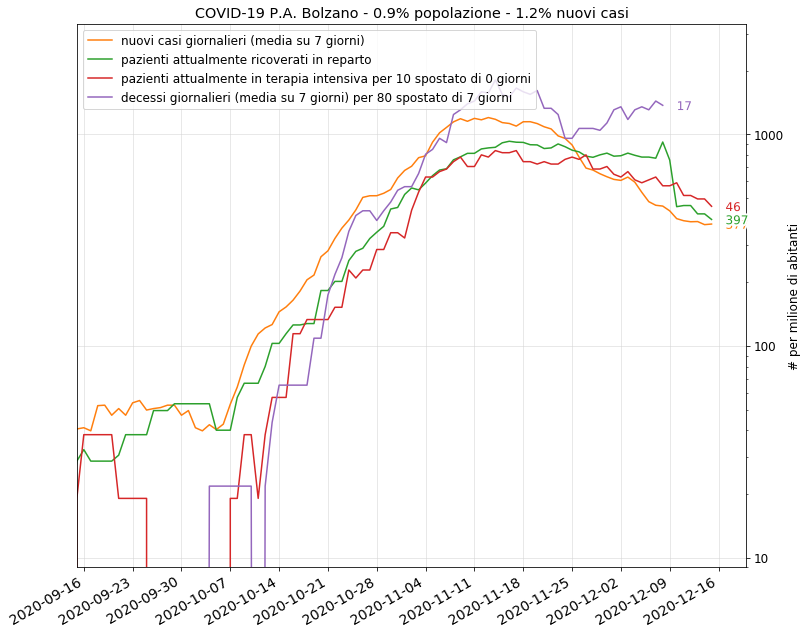

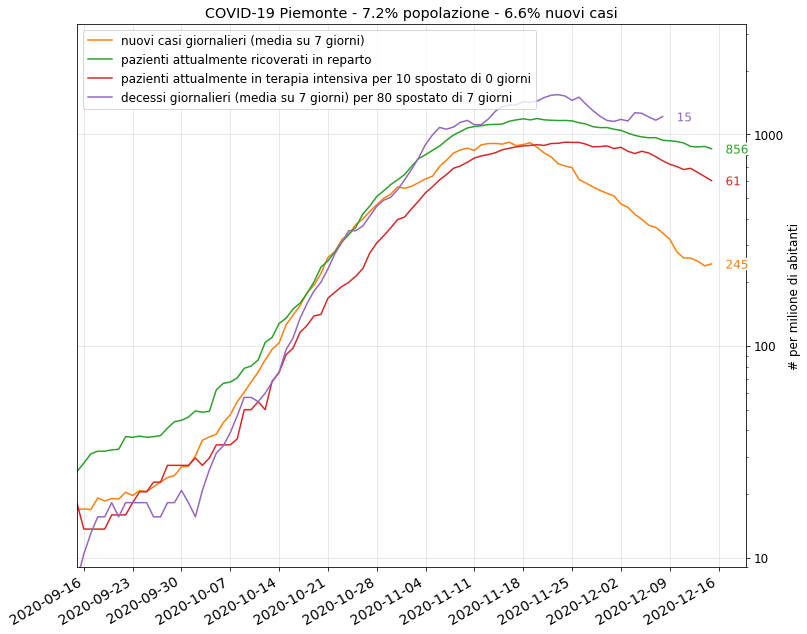

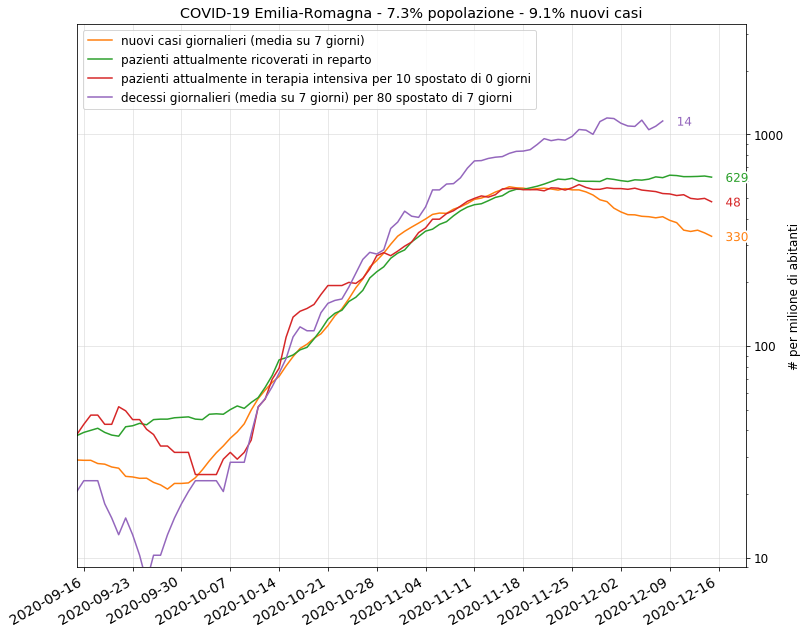

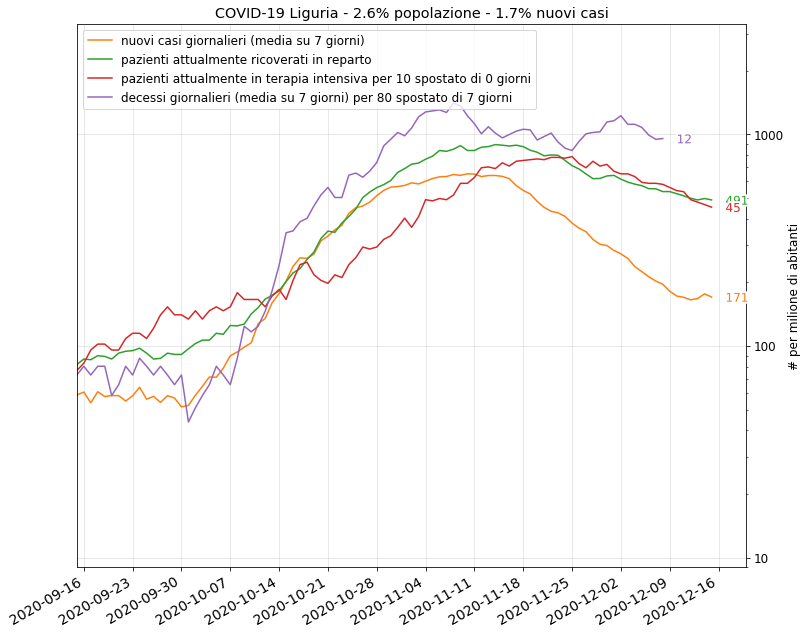

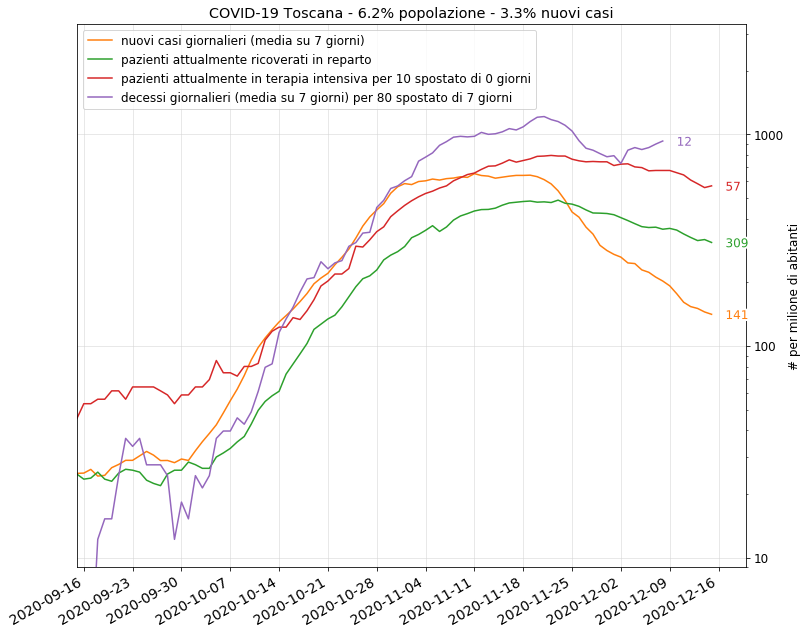

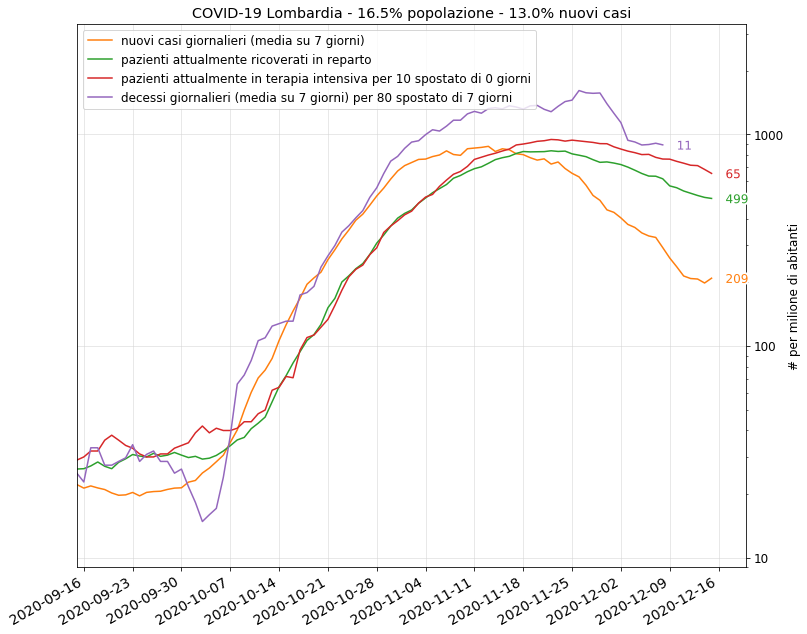

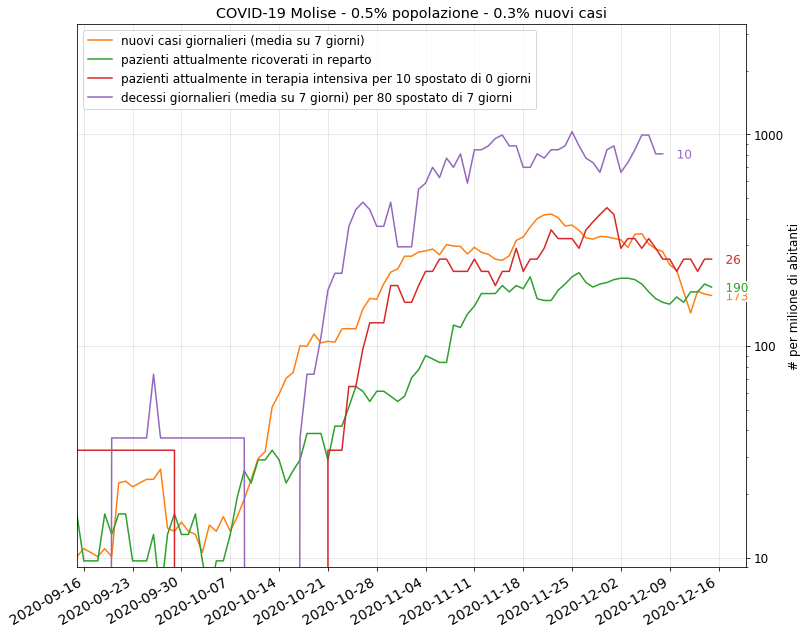

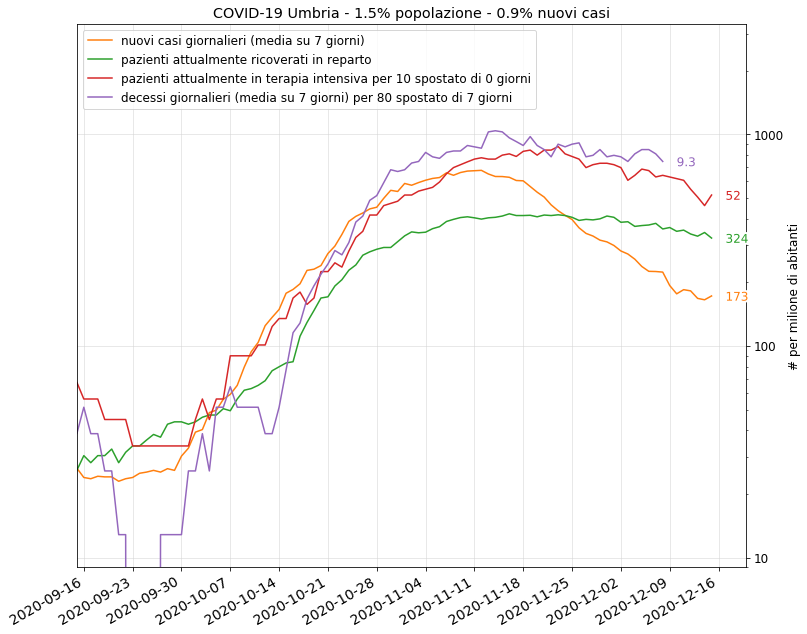

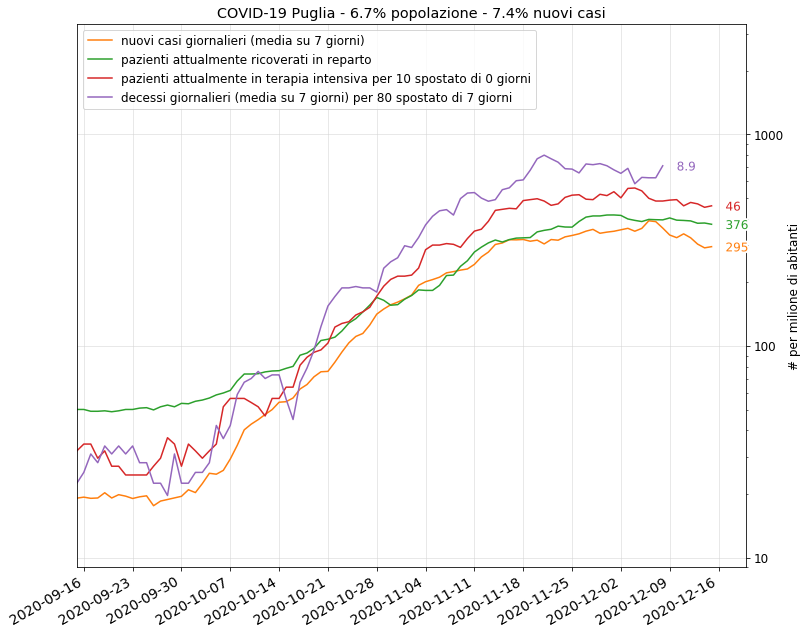

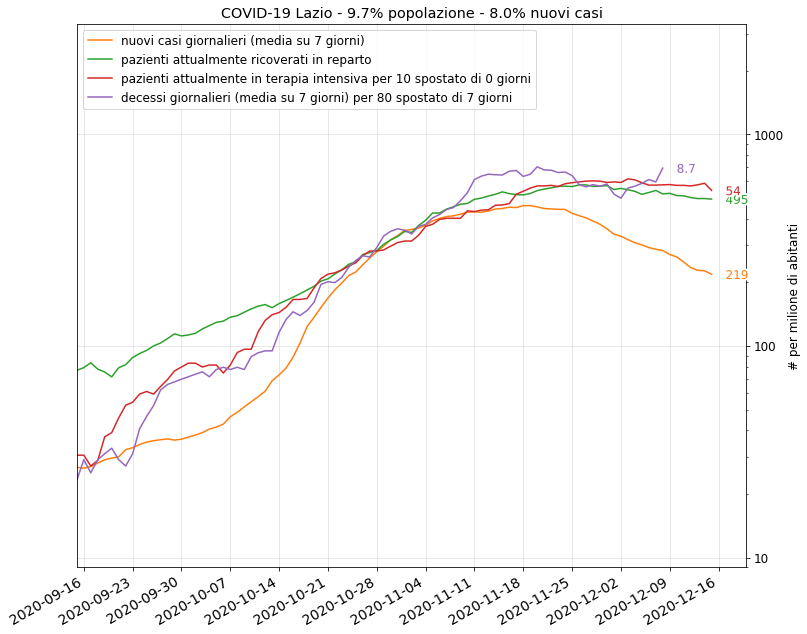

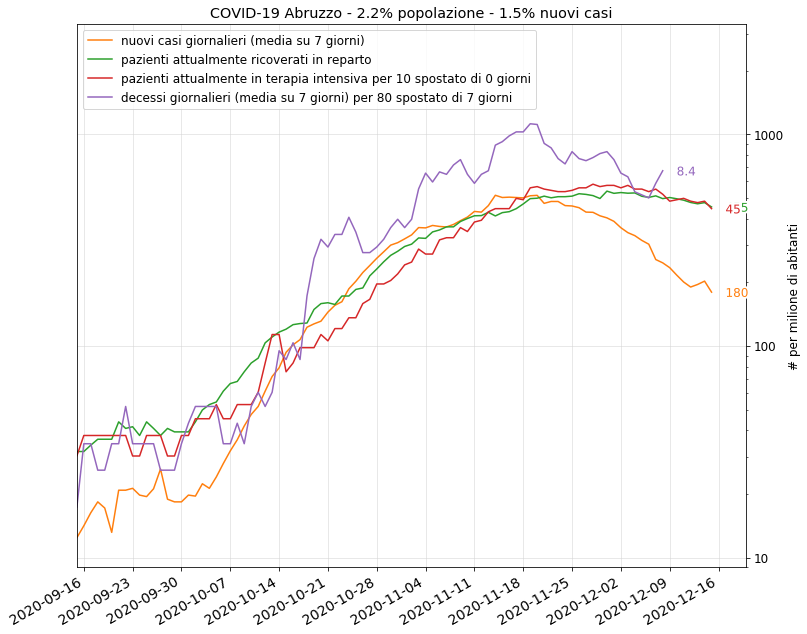

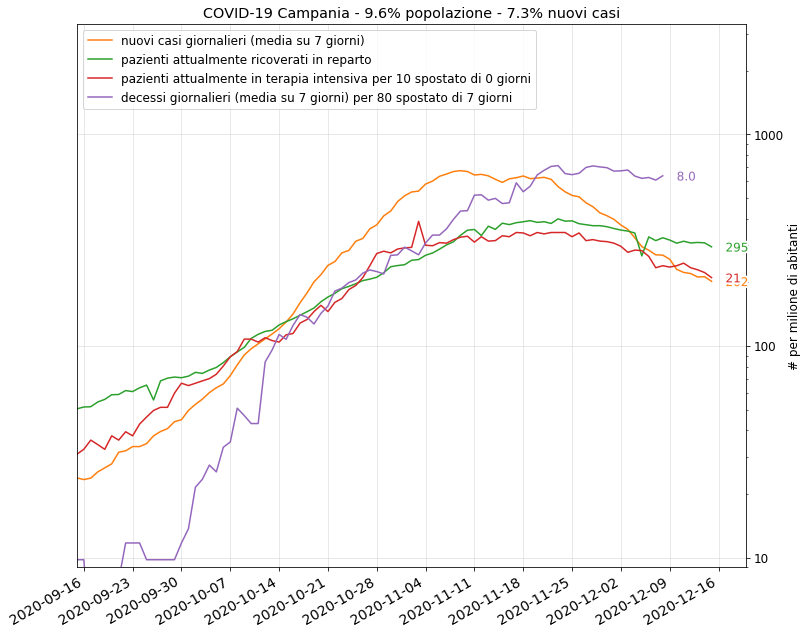

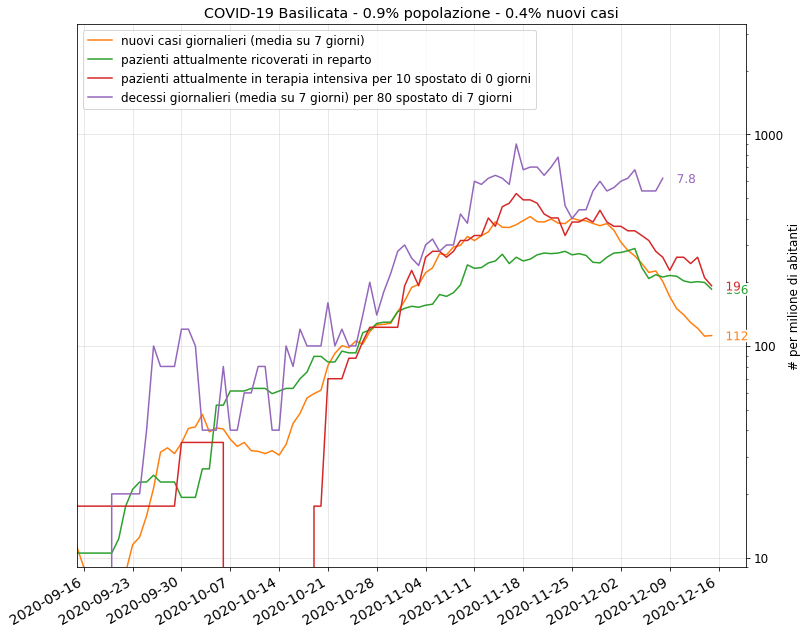

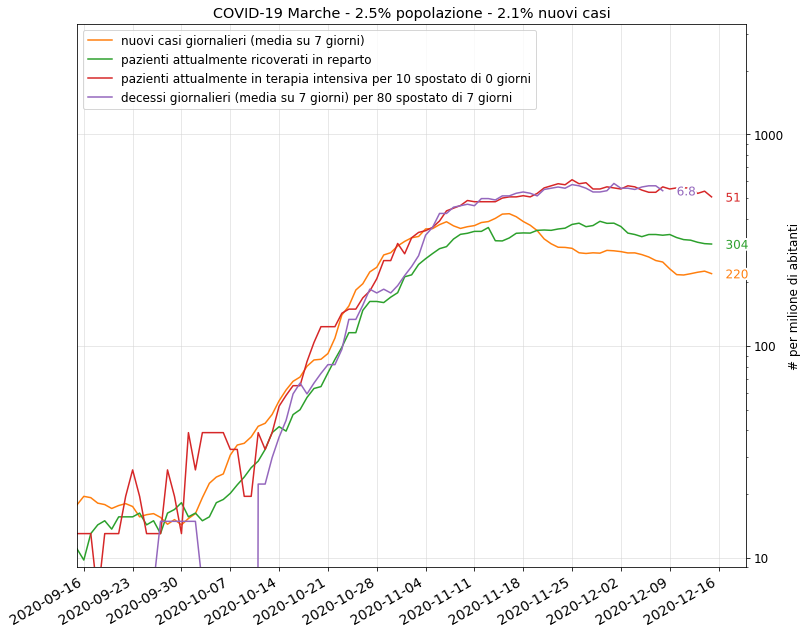

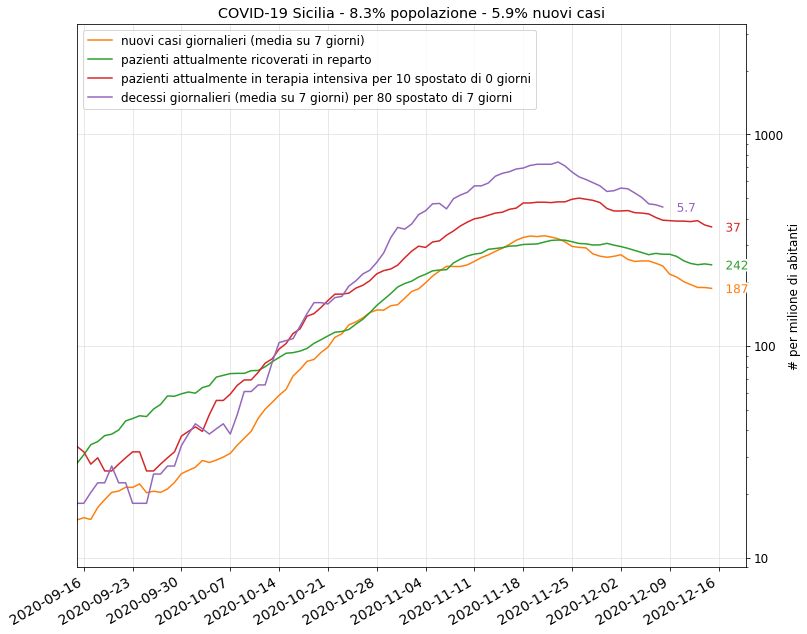

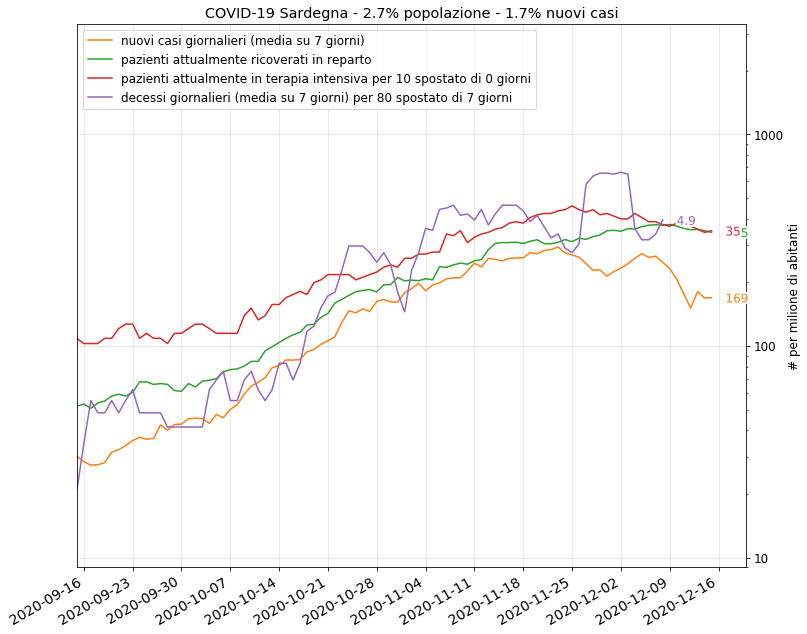

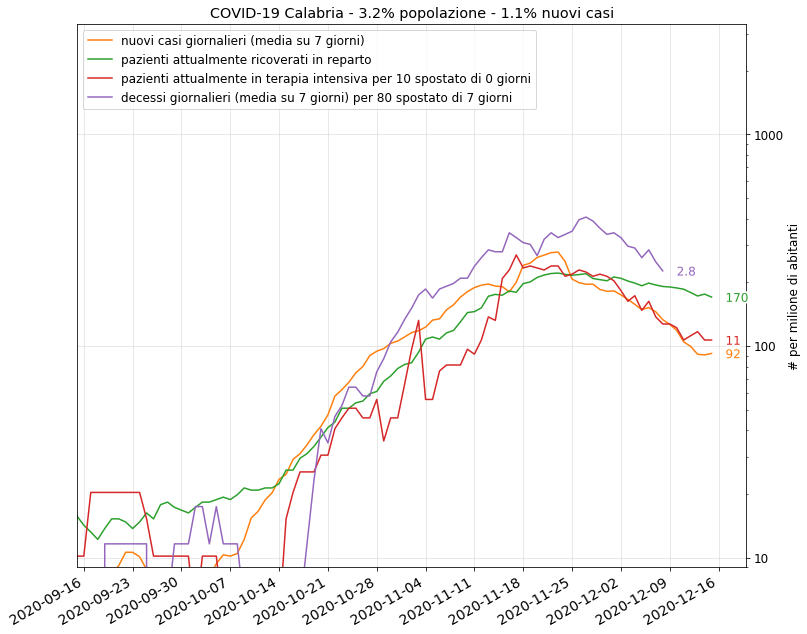

In [225]:
SHOW_REGIONS = {'daily_prevalence7', 'current_severe_pm','current_critical_pm', 'daily_mortality7'}
# SHOW_REGIONS = {'daily_prevalence7', 'daily_mortality7'}

for region in REGIONS:
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    
    _, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (10 * 0.9, 3000 / 0.9)})
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fitsk), color, ratio, delay in zip(fit_kinds.items(), PALETTE_ONE, [1, 1, 1, 10, 80], [0, 0, 0, 0, 7]):
        if SHOW_REGIONS is not None and kind not in SHOW_REGIONS:
            continue

        label = LABEL[kind] if ratio == 1 else LABEL[kind] + f' per {ratio} spostato di {delay} giorni'
        covid19.plot.plot_data(ax, ds_region[kind], label=label, color=color, delay=-delay, ratio=1 / ratio, marker=None, date_interval=7, annotate=True)
        #if kind == 'daily_prevalence7':
        #    ax.bar(ds_region.time, ds_region[kind[:-1]], color=color, alpha=0.25, label='nuovi casi giornalieri')
        #    ax.bar(ds_region.time[6::7], ds_region[kind[:-1]][6::7], color=color, alpha=0.25)
        #for fit in fitsk:
        #covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-7, 7], alpha=0.2)

    pop_perc = ds_region.population.values / ds_italy.population.values * 100
    pos_perc = ds_region['daily_confirmed7'][-1].values / ds_italy['daily_confirmed7'][-1].values * 100
    ax.set_title(f'COVID-19 {region} - {pop_perc:.1f}% popolazione - {pos_perc:.1f}% nuovi casi' )
    ax.set(xlabel="", ylabel="# per milione di abitanti")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
    ax.legend(loc='upper left')


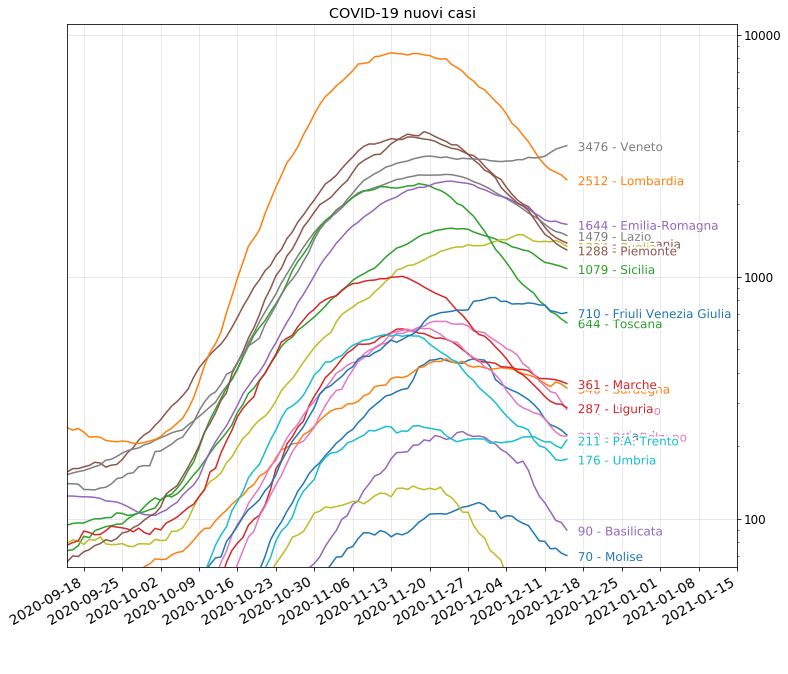

In [238]:
_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-09-15'), np.datetime64('2021-01-15')), 'yscale': 'log', 'ylim': (70 * 0.9, 10000 / 0.9)})
ax.yaxis.grid(color='lightgrey', linewidth=0.5)
ax.xaxis.grid(color='lightgrey', linewidth=0.5)

for region, color in zip(reversed(REGIONS), itertools.cycle(PALETTE_ONE)):
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    

    kind = 'daily_confirmed14'
    label = LABEL[kind] if ratio == 1 else LABEL[kind] + f' per {ratio} spostato di {delay} giorni'
    covid19.plot.plot_data(ax, ds_region[kind], label=region, color=color, marker=None, date_interval=7, annotate=True, annotate_add_label=True)

ax.set_title(f'COVID-19 nuovi casi' )
_ = ax.set(xlabel="", ylabel="")
# _ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))


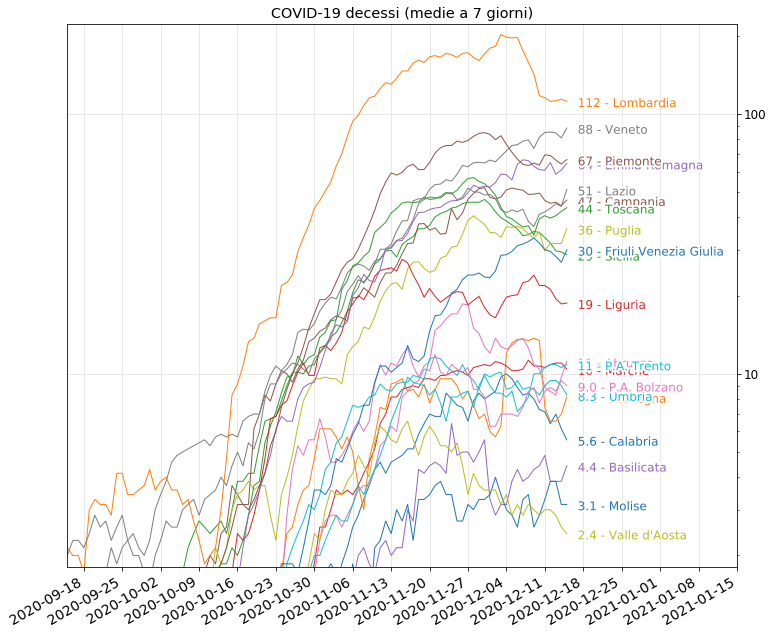

In [239]:
_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-09-15'), np.datetime64('2021-01-15')), 'yscale': 'log', 'ylim': (2 * 0.9, 200 / 0.9)})
ax.yaxis.grid(color='lightgrey', linewidth=0.5)
ax.xaxis.grid(color='lightgrey', linewidth=0.5)

for region, color in zip(reversed(REGIONS), itertools.cycle(PALETTE_ONE)):
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    

    kind = 'daily_deaths7'
    label = LABEL[kind] if ratio == 1 else LABEL[kind] + f' per {ratio} spostato di {delay} giorni'
    covid19.plot.plot_data(ax, ds_region[kind], label=region, linewidth=1, color=color, marker=None, date_interval=7, annotate=True, annotate_add_label=True)

ax.set_title(f'COVID-19 decessi (medie a 7 giorni)' )
_ = ax.set(xlabel="", ylabel="")
# _ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))


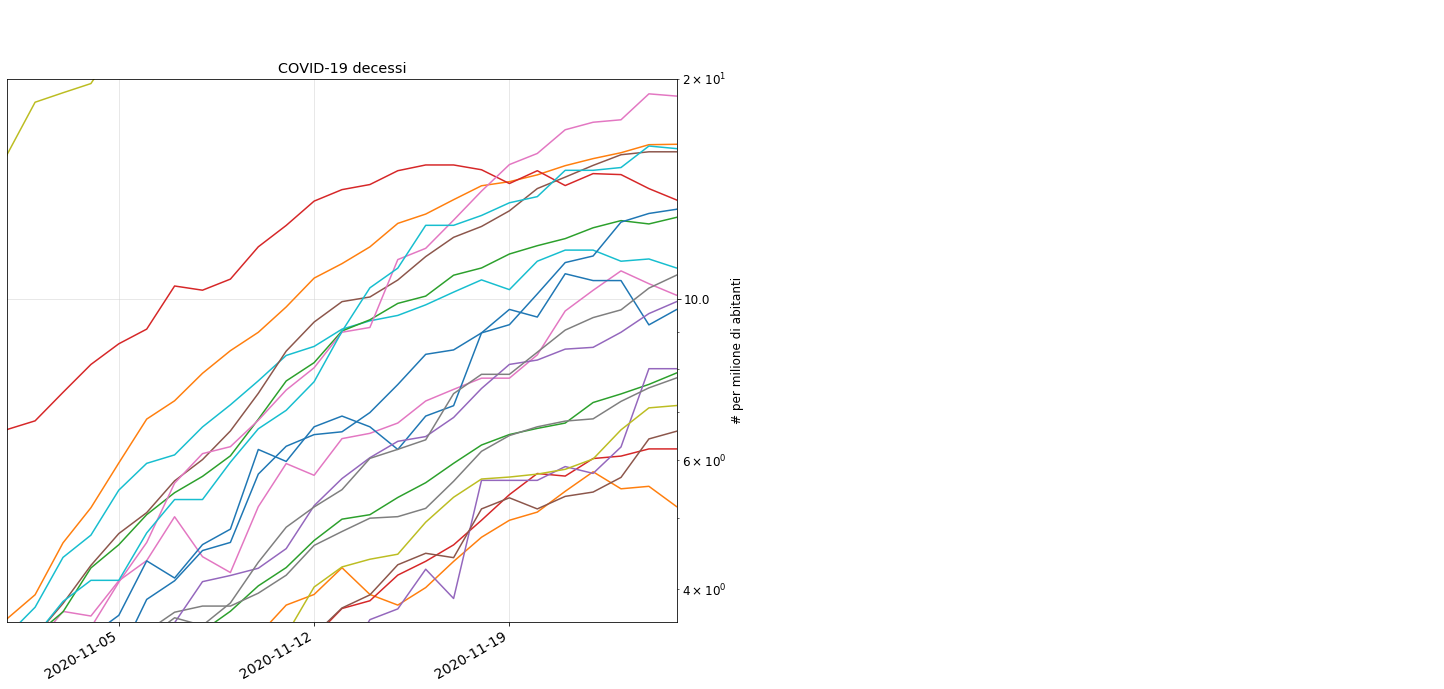

In [228]:
_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-11-01'), np.datetime64('2020-11-25')), 'yscale': 'log', 'ylim': (4 * 0.9, 18 / 0.9)})
ax.yaxis.grid(color='lightgrey', linewidth=0.5)
ax.xaxis.grid(color='lightgrey', linewidth=0.5)

for region, color in zip(reversed(REGIONS), itertools.cycle(PALETTE_ONE)):
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    

    kind = 'daily_mortality14'
    label = LABEL[kind] if ratio == 1 else LABEL[kind] + f' per {ratio} spostato di {delay} giorni'
    covid19.plot.plot_data(ax, ds_region[kind], label=region, color=color, marker=None, linewidth=1.5, date_interval=7, annotate=True, annotate_add_label=True)

ax.set_title(f'COVID-19 decessi' )
_ = ax.set(xlabel="", ylabel="# per milione di abitanti")
# _ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))


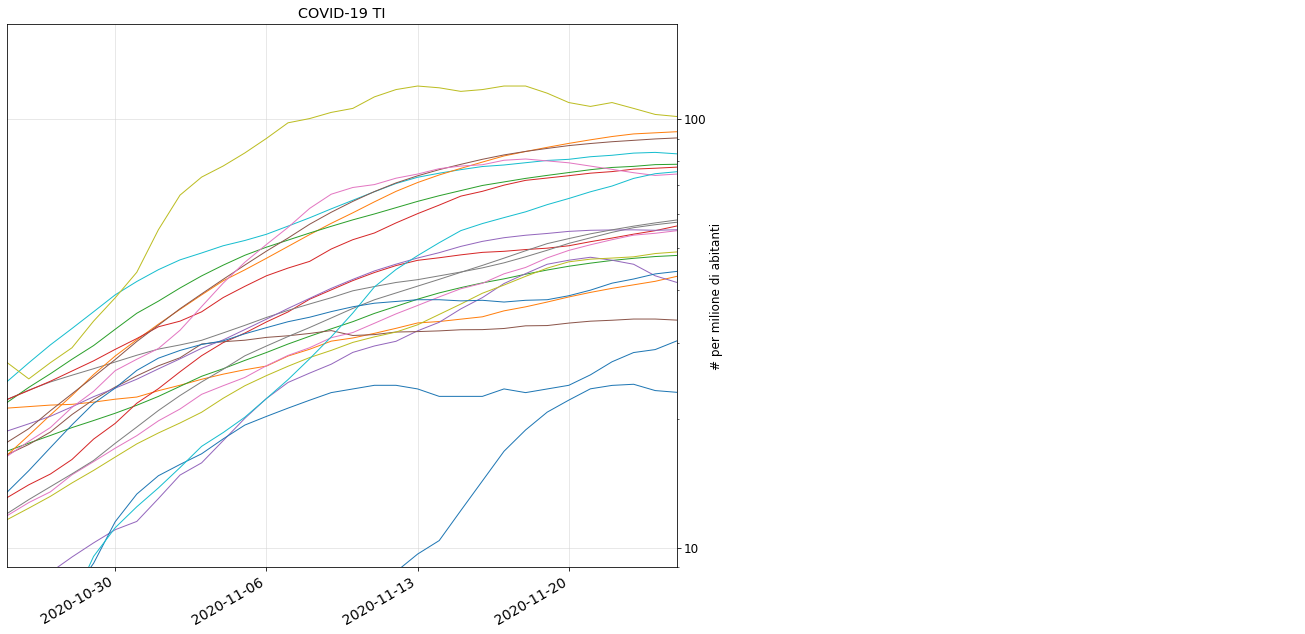

In [229]:
_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': (np.datetime64('2020-10-25'), np.datetime64('2020-11-25')), 'yscale': 'log', 'ylim': (10 * 0.9, 150 / 0.9)})
ax.yaxis.grid(color='lightgrey', linewidth=0.5)
ax.xaxis.grid(color='lightgrey', linewidth=0.5)

for region, color in zip(reversed(REGIONS), itertools.cycle(PALETTE_ONE)):
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    

    kind = 'current_critical_pm'
    label = LABEL[kind] if ratio == 1 else LABEL[kind] + f' per {ratio} spostato di {delay} giorni'
    covid19.plot.plot_data(ax, ds_region[kind].rolling({'time': 7}).mean(), label=region, color=color, marker=None, linewidth=1, date_interval=7, annotate=True, annotate_add_label=True)

ax.set_title(f'COVID-19 TI' )
_ = ax.set(xlabel="", ylabel="# per milione di abitanti")
# _ = ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))


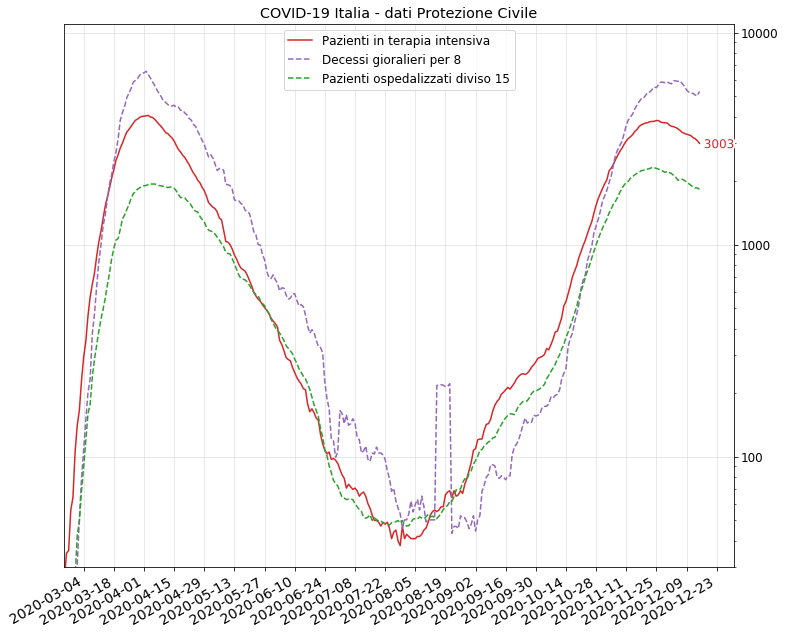

In [241]:
_, ax = covid19.plot.subplots(subplot_kw={'yscale': 'log', 'xlim': (np.datetime64('2020-02-24'), np.datetime64('2020-12-31')), 'ylim': (30, 11000)})
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, label='Pazienti in terapia intensiva', color='tab:red', annotate=True)
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], marker=None, ratio=1/8, label='Decessi gioralieri per 8', color='tab:purple', date_interval=14, linestyle='--')
covid19.plot.plot_data(ax, ds_italy['current_severe'], marker=None, ratio=15, label='Pazienti ospedalizzati diviso 15', color='tab:green', date_interval=14, linestyle='--')
_ = ax.legend(loc='upper center')
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

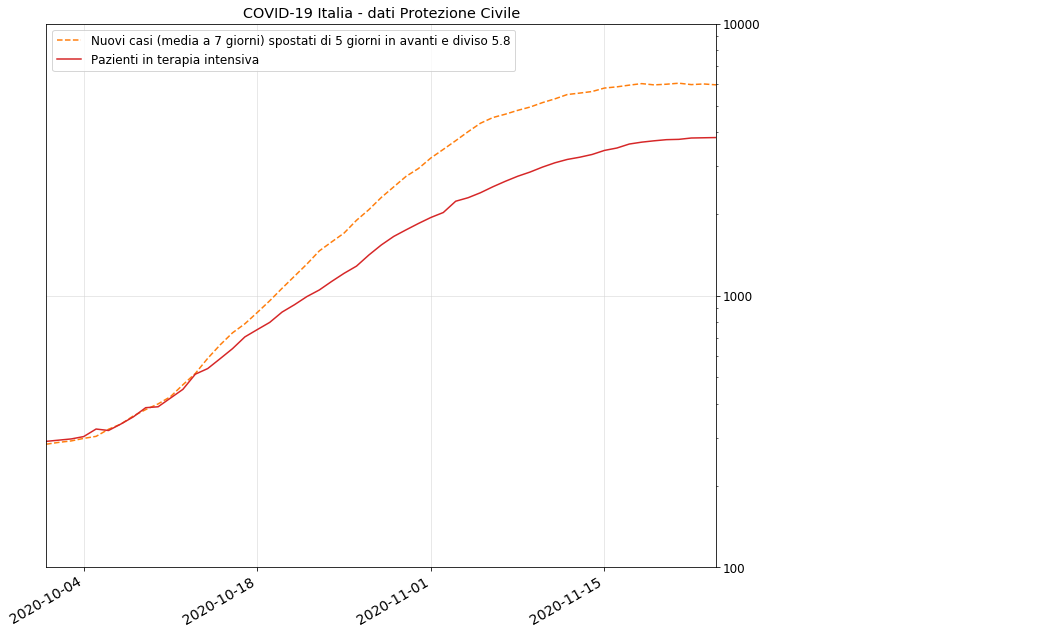

In [231]:
_, ax = covid19.plot.subplots(subplot_kw={'yscale': 'log', 'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-11-24')), 'ylim': (100, 10000)})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], marker=None, delay=5, ratio=5.8, label='Nuovi casi (media a 7 giorni) spostati di 5 giorni in avanti e diviso 5.8', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, label='Pazienti in terapia intensiva', color='tab:red', date_interval=14, annotate=True)
_ = ax.legend(loc='upper left')
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

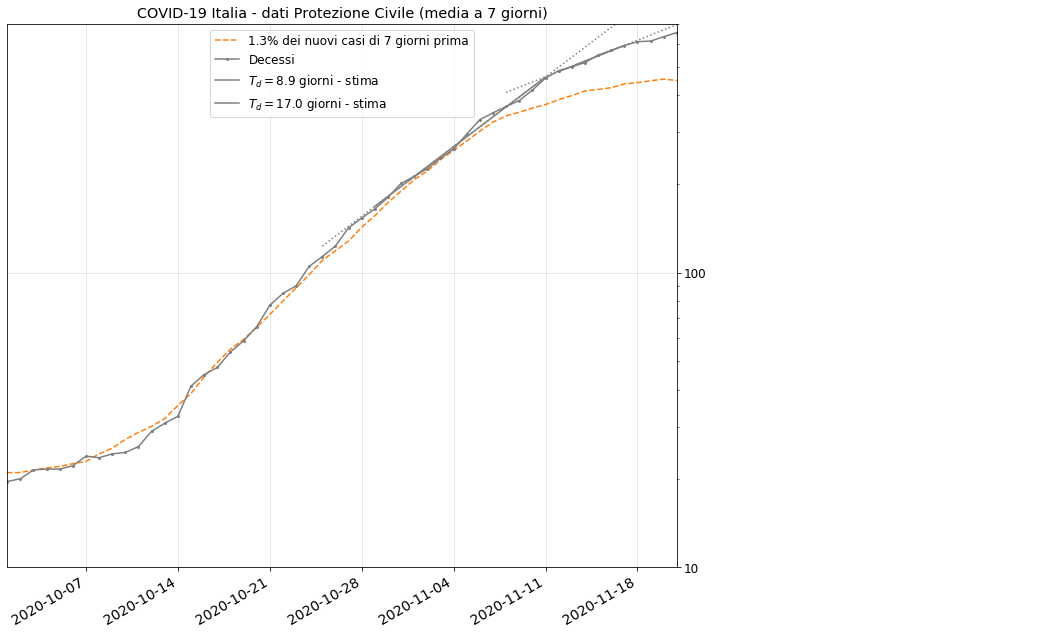

In [232]:
shift = 7
scale = 0.013

color_deaths = (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)

_, ax = covid19.plot.subplots(subplot_kw={'xlim': (np.datetime64('2020-10-01'), np.datetime64('2020-11-21')), 'yscale': 'log', 'ylim': (10, 700)})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], marker=None, delay=shift, ratio=1/scale, label=f'{scale * 100:.2g}% dei nuovi casi di {shift} giorni prima', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], label='Decessi', color=color_deaths, date_interval=7, annotate=True)
covid19.plot.plot_fit(ax, fits['daily_deaths7'][-2], marker=None, color=color_deaths, extrapolate=(-4, 7), label='stima')
covid19.plot.plot_fit(ax, fits['daily_deaths7'][-1], marker=None, color=color_deaths, extrapolate=(-4, 7), label='stima')
_ = ax.legend(loc='upper center')
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile (media a 7 giorni)', ylabel='', xlabel='')

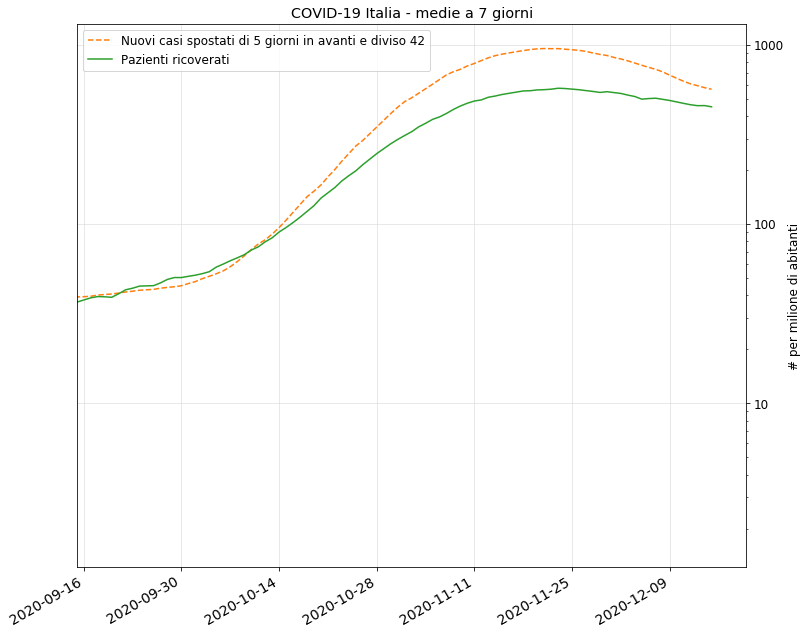

In [233]:
_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed14'], marker=None, delay=0, ratio=35, label='Nuovi casi spostati di 5 giorni in avanti e diviso 42', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['current_severe_pm'], marker=None, label='Pazienti ricoverati', color='tab:green', date_interval=14,)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - medie a 7 giorni', ylabel='# per milione di abitanti', xlabel='')

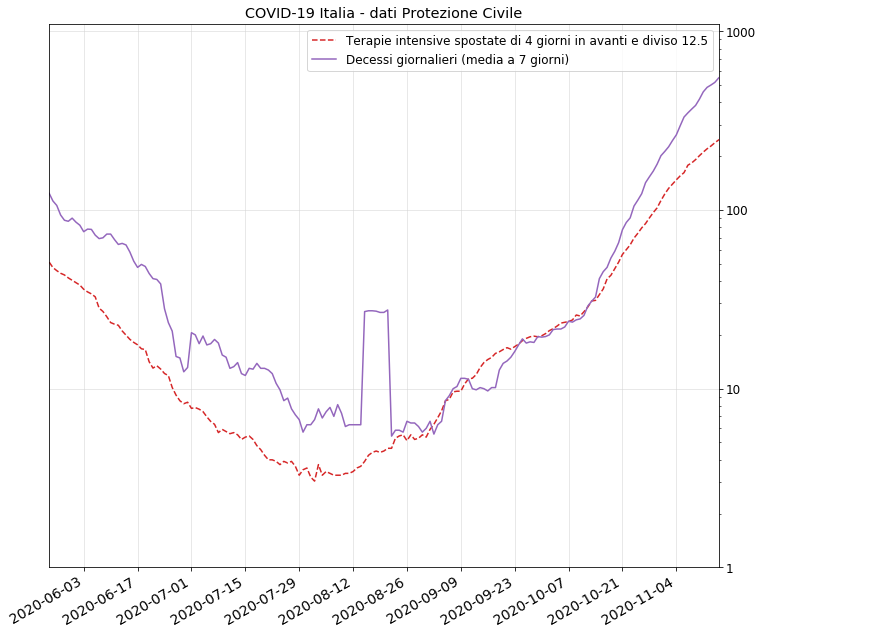

In [234]:
_, ax = covid19.plot.subplots(subplot_kw={'xlim': (np.datetime64('2020-05-25'), np.datetime64('2020-11-15')), 'yscale': 'log', 'ylim': (1, 1100)})
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, delay=4, ratio=12.5, label='Terapie intensive spostate di 4 giorni in avanti e diviso 12.5', color='tab:red', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], marker=None, label='Decessi giornalieri (media a 7 giorni)', color='tab:purple', date_interval=14, annotate=True)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

NameError: name 'daily_confirmed_estimate' is not defined

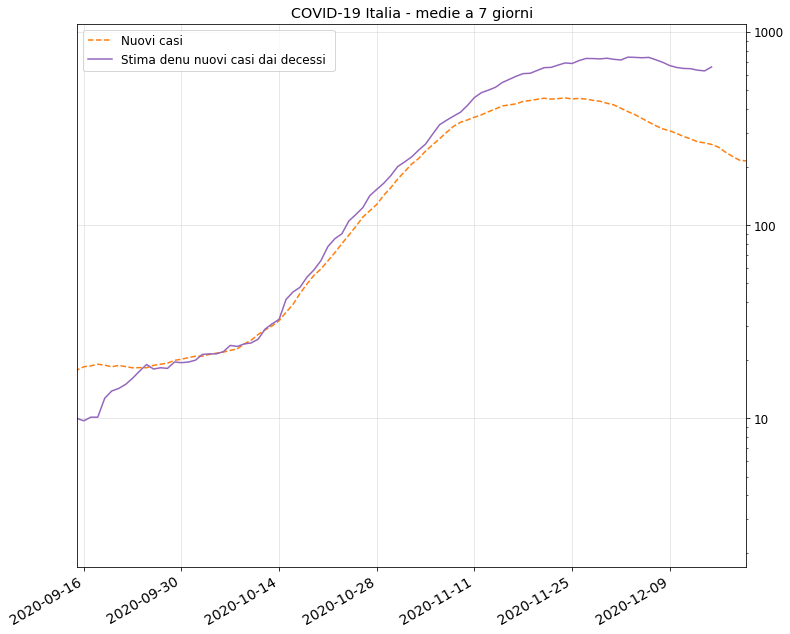

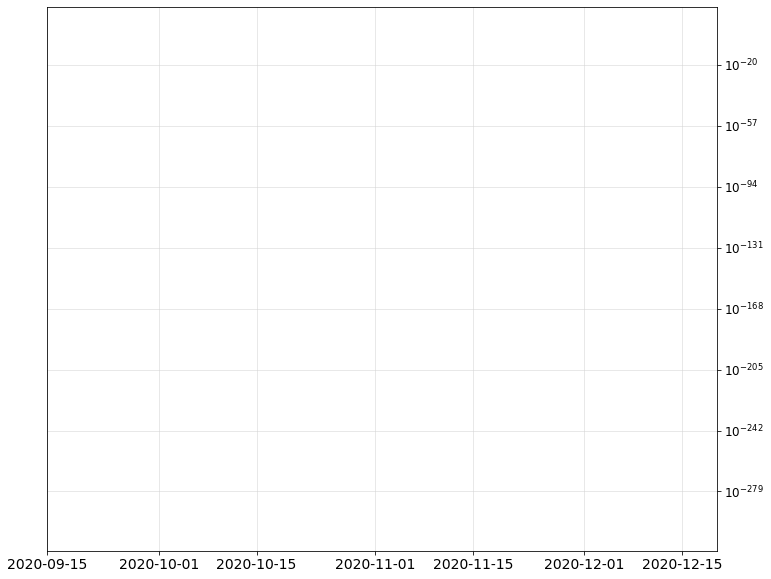

In [235]:
shift = 8
scale = 0.013

_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'], delay=shift, ratio=1/scale, marker=None, label='Nuovi casi', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, ds_italy['daily_deaths7'], marker=None, label='Stima denu nuovi casi dai decessi ', color='tab:purple', date_interval=14)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - medie a 7 giorni', ylabel='', xlabel='')

_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM, 'yscale': 'log'})
covid19.plot.plot_data(ax, daily_confirmed_estimate / ds_italy['daily_confirmed7'], marker=None, label='Decessi giornalieri', color='tab:purple', date_interval=14,)
_ = ax.legend()
_ = ax.set(title='COVID-19 Italia - dati Protezione Civile', ylabel='', xlabel='')

In [ ]:
SHOW_REGIONS = None  # {'daily_prevalence7', 'current_severe_pm','current_critical_pm', 'daily_mortality7'}

for region in REGIONS:
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    
    _, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM, 'yscale': 'log', 'ylim': (0.02 * 0.9, 5000 / 0.9)})
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fitsk), color in zip(fit_kinds.items(), PALETTE_ONE):
        if SHOW_REGIONS is not None and kind not in SHOW_REGIONS:
            continue

        label = LABEL[kind]
        covid19.plot.plot_data(ax, ds_region[kind], label=label, color=color, marker=None, date_interval=14, annotate=True)
        for fit in fitsk:
            covid19.plot.plot_fit(ax, fit, color=color, marker=None, label=f'stima esponenziale', extrapolate=[-7, 7], alpha=0.2)
    pop_perc = ds_region.population.values / ds_italy.population.values * 100
    pos_perc = ds_region['daily_confirmed7'][-1].values / ds_italy['daily_confirmed7'][-1].values * 100
    ax.set_title(f'COVID-19 {region} - {pop_perc:.1f}% popolazione - {pos_perc:.1f}% positivi' )
    ax.set(xlabel="", ylabel="# per milione di abitanti")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
    ax.legend(loc='lower left')


In [ ]:
da = ds_italy['current_critical'][159:]
for i in range(20):
    old = ds_italy['current_critical'][i]
    new = da[(da < old).argmin()]
    print(str(old.time.values)[:10], old.values, ds_italy['daily_deaths'].sel(time=old.time.values).values, str(new.time.values)[:10], new.values)

In [ ]:
daa = ds_italy['current_critical']
for i in range(10):
    try:
        new = da[i * 7 + 3]
    except:
        new = da[-1]
    # print(new, daa.values, (daa > new).values)
    old = daa[(daa <= new).argmin() - 1]
    old1 = daa[(daa <= new).argmin()]
    print(
        str(old.time.values)[:10],
        old.values,
        ds_italy['daily_deaths'].sel(time=old.time.values).values,
        ds_italy['current_severe'].sel(time=old.time.values).values,
        str(new.time.values)[:10],
        new.values,
        ds_italy['daily_deaths'].sel(time=new.time.values).values,
        ds_italy['current_severe'].sel(time=new.time.values).values,
    )

In [ ]:
daa

In [ ]:
a = xr.DataArray(
    [56, 64, 105, 140, 166, 229, 295, 351, 462, 567, 650, 733],
    dims=['time'],
    coords={
        'time': ('time', [np.datetime64(t) for t in ['2020-08-18', '2020-08-25', '2020-09-01', '2020-09-08', '2020-09-15', '2020-09-22', '2020-09-29', '2020-10-06', '2020-10-13', '2020-10-20', '2020-10-27', '2020-11-03']]),
        'old_time': ('time', ['2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09']),
    }
)
a

In [ ]:
# import matplotlib.patheffects as patheffects

f, ax = covid19.plot.subplots()
covid19.plot.plot_data(ax, da, marker=None, color='tab:red')
# covid19.plot.plot_data(ax, ds_italy['daily_confirmed7'][159:], marker=None, delay=18, ratio=4.6, label='Nuovi casi spostati di 18 giorni in avanti e diviso 4.5', color='tab:orange', linestyle='--')
covid19.plot.plot_data(ax, a, linestyle='', color='black')
for xp, l in zip(a.time.values, a.old_time.values):
    yp = a.sel(time=xp).values
    ax.annotate(l, (xp - 3 * np.timedelta64(1, 'D'), yp + 10), path_effects=[
                patheffects.Stroke(linewidth=4, foreground='white'),
                patheffects.Normal(),
            ])
ax.set(title='COVID-19 pazienti in terapia intensiva', xlabel='', ylim=(0, 820))

In [ ]:
f, ax = covid19.plot.subplots()
covid19.plot.plot_data(ax, ds_italy['current_critical'], marker=None, color='tab:red', date_interval=14)
ax.set(
    ylim=(0, 500),
)
for i in range(10):
    b = ds_italy['current_critical'][i + 2]
    c = da[(da < b).argmin()]
    ax.plot([b.time.values, c.time.values + 3 * np.timedelta64(day=1)], [b.values, b.values], color='tab:red')



In [ ]:
import math

peak_infected_percent = .6
peak_infected = peak_infected_percent * ds_italy.population.values
IFR_base = .006

T_ds_up = [7, 10, 20, 30]

print(f"{peak_infected:,.0f} {peak_infected * IFR_base:,.0f}")

In [ ]:
def Rt(T_d=7, onset_day=5):
    return 2 ** (onset_day / T_d)

print(f"{Rt():.2f}")

In [ ]:
1.64*.8

In [ ]:
2 ** ((t - t_0) / T_d)

T_d / ln(2) * 2 ** ((t - t_0) / T_d) + C

peak_infected = T_d / ln(2) * 2 ** ((t - t_0) / T_d)

ln2(peak_infected * ln(2) / T_d) * T_d = (t - t_0)

In [ ]:
def delta_time(T_d, peak_infected):
    return math.log2(peak_infected * math.log(2) / T_d) * T_d

delta_time(7, peak_infected)

In [ ]:
7 / math.log(2) * 2 ** ((152.5) / 7)

In [ ]:
cumul = 0
T_d = 7
for d in range(500):
    infected = 2 ** ((d + 107.5066) / T_d)
    cumul += infected
    theory = T_d / math.log(2) * 2 ** (d / T_d)
    print(f"{d} {np.datetime64('2020-10-25') + d * DAY:.10s} {infected/2:,.0f} {infected:,.0f} {cumul + 3458000:,.0f}")


In [ ]:
ds_italy['daily_confirmed'].sel(time=slice('2020-06-01')).sum().values * 2 + 3000000

In [ ]:
def approx_tot(T_d):
    for d in range(100, 160):
        print(f"{np.datetime64('2020-07-16') + d * DAY:.10s} {d - 100} {2 ** (d / T_d):,.0f} {T_d / math.log(2) * 2 ** (d / T_d) + 3_500_000:,.0f}")
approx_tot(7)

In [195]:
from scipy import stats

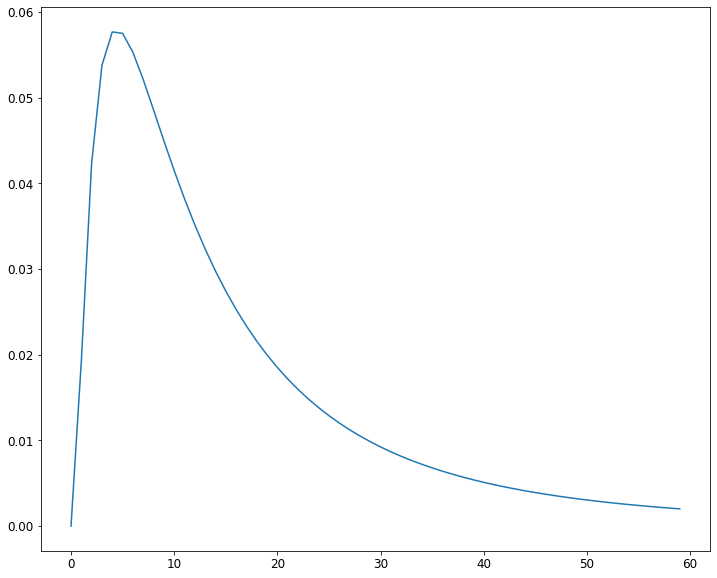

In [196]:
x = np.arange(60)

sigma = 1
mu = 10
pd = stats.lognorm.pdf(x, sigma, scale=12)
pd /= sum(pd)
_ = plt.plot(x, pd)

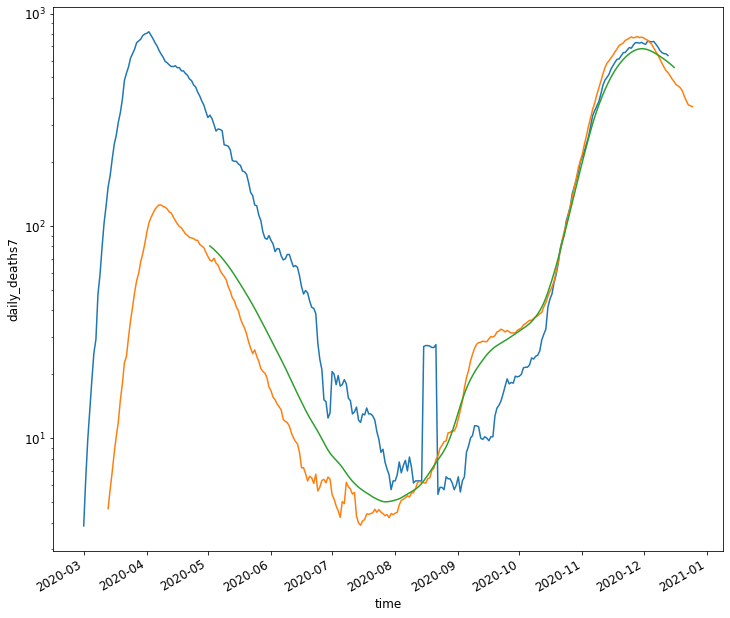

In [197]:
c = ds_italy['daily_confirmed7']
ds_italy['daily_deaths7'].plot(yscale='log')
plt.plot(ds_italy.time + 12 * DAY, c / 45)
#ds_italy['current_critical'].plot()
plt.plot(ds_italy.time + 3 * DAY, np.convolve(c, pd)[:-59] / 43)